# CITE-seq protein acceleration analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import velocyto as vcy
%config InlineBackend.figure_format = 'retina'

Import protein count data. Acquired from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100866, file **GSE100866_PBMC_vs_flow_10X-ADT_umi.csv.gz**.


In [2]:
import csv
with open('velocyto_data/SPBMC/adt_data/GSE100866_PBMC_vs_flow_10X-ADT_umi.csv','r') as dest_f:
    data_iter = csv.reader(dest_f,
                           delimiter = ',',
                           quotechar = '"')
    data = [data for data in data_iter]
prot_count_array = np.asarray(data)
prot_cells = prot_count_array[0,1:]
prot_genes = prot_count_array[1:,0]

Display proteins with available data. 

In [3]:
prot_genes

array(['CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16', 'CD14',
       'CD11c', 'CD19'], dtype='<U16')

`cellranger` processing:

`cellranger count --id=(desired bam directory) --transcriptome=(transcriptome directory) --fastqs=(fastq directory) --localcores=40 --localmem=100 --chemistry=SC3Pv2`

`velocyto` processing:
`velocyto run10x --samtools-threads 60 --samtools-memory 5000 (desired bam directory) (transcriptome directory)/genes/genes.gtf`



Import `velocyto` command-line interface (CLI) pipeline output.


In [4]:
vlm = vcy.VelocytoLoom("velocyto_data/SPBMC/SPBMC_run3.loom")

Select 3000 genes with highest variability.

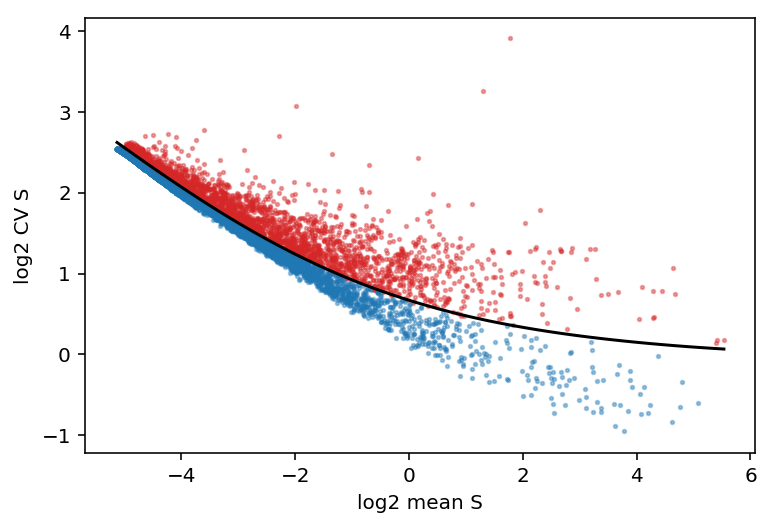

In [5]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)

Define relationship between proteins and source mRNA. Define mRNA to be used for phase portrait visualization and velocity calculation.

In [6]:
gene_dict = {'CD3':['CD3D','CD3E','CD3G'], 
             'CD4':['CD4'],
             'CD8':['CD8A','CD8B'],
             'CD2':['CD2'],
             'CD45RA':['PTPRC'],
             'CD57':['B3GAT1'],
             'CD16':['FCGR3A','FCGR3B'],
             'CD14':['CD14'],
             'CD11c':['ITGAX'],
             'CD19':['CD19']}

InvertDict = lambda d: dict( (v,k) for k in d for v in d[k] )


mrna_targets = ['CD3D','CD3E','CD3G','CD4','CD8A','CD8B','CD2',
                'PTPRC','FCGR3A','CD14','ITGAX','CD19']
vel_prot_gen = ['CD3D','CD8A','FCGR3A','CD14','ITGAX','CD19','CD2']
vel_prot_prot = ['CD3','CD8','CD16','CD14','CD11c','CD19','CD2']

Define inverse relationship.

In [7]:
prot_dict = InvertDict(gene_dict)

Append target genes even if variability is relatively low for RNA velocity phase plots. Filter genes.

In [8]:
chosen_genes = np.asarray([np.where(vlm.ra['Gene'] == mrna_targets[i])[0][0] for i in range(len(mrna_targets))])
vlm.cv_mean_selected[chosen_genes] = True
vlm.filter_genes(by_cv_vs_mean=True)

In [9]:
print(len(vlm.ca['CellID']))

1789


Check intersection of cell UMIs. 

In [10]:
j = vlm.ca['CellID'][0].find(':')
rna_cells = np.asarray([cell_str[j+1:-1] for cell_str in vlm.ca['CellID']])
shared_cells = [cell_tag for cell_tag in rna_cells if cell_tag in prot_cells]

print('ADT cell number: '+str(len(prot_cells)))
print('RNAseq cell number: '+str(len(rna_cells)))
print('Shared cells: '+str(len(shared_cells)))

ADT cell number: 7985
RNAseq cell number: 1789
Shared cells: 1780


In [11]:
shared_cell_prot_ind = [np.where(prot_cells==cell)[0][0] for cell in shared_cells]
shared_cell_rna_ind = [np.where(rna_cells==cell)[0][0] for cell in shared_cells]

Extract and normalize spliced, unspliced, protein data.

In [12]:
S = vlm.S[:,:][:,shared_cell_rna_ind]
U = vlm.U[:,:][:,shared_cell_rna_ind]

In [13]:
S_cellsize = S.sum(0)
S_sz = S / S_cellsize * np.median(S_cellsize)
S_norm = np.log2(S_sz + 1)

In [14]:
U_cellsize = U.sum(0)
U_sz = U / U_cellsize * np.median(U_cellsize)
U_norm = np.log2(U_sz + 1)

In [15]:
P = prot_count_array[1:,1:][:,shared_cell_prot_ind].astype('float')
P_cellsize = P.sum(0)
P_sz = P / P_cellsize * np.median(P_cellsize)
P_norm = np.log2(P_sz+1)
space = P_norm.T

In [16]:
P_med = np.median(P,1)

Perform knn imputation.

In [17]:
k = 400
from sklearn.neighbors import NearestNeighbors
nn=NearestNeighbors(n_neighbors=k, n_jobs=8, )
nn.fit(space)
knn=nn.kneighbors_graph(X=None, mode='distance')
conn = (knn>0).astype(float)
from scipy import sparse
smooth = conn.multiply(1./sparse.csr_matrix.sum(conn, axis=1))
Sx = sparse.csr_matrix.dot(S, smooth.T)
Ux = sparse.csr_matrix.dot(U, smooth.T)
Px = sparse.csr_matrix.dot(P, smooth.T)

In [18]:
filt_genes = vlm.ra['Gene']

Find clusters using protein space adjacency data.

In [19]:
import louvain
import igraph as ig
g=ig.Graph.Adjacency(conn.todense().tolist())
p=louvain.find_partition(g,louvain.ModularityVertexPartition)
tag_list = np.zeros(conn.shape[0])
for x in range(len(p)):
    tag_list[p[x]]=int(x)

In [20]:
tT = [int(X) for X in tag_list]
NUM_CLUS = max(tT)+1
COLORS=np.asarray([[0, 0.4470, 0.7410],
        [0.8500, 0.3250, 0.0980],
        [0.9290, 0.6940, 0.1250],
        [0.4940, 0.1840, 0.5560],
        [0.4660, 0.6740, 0.1880]])
lab = ['CD4+ T','B','Mono.','NK','CD8+ T']


Visualize clusters.

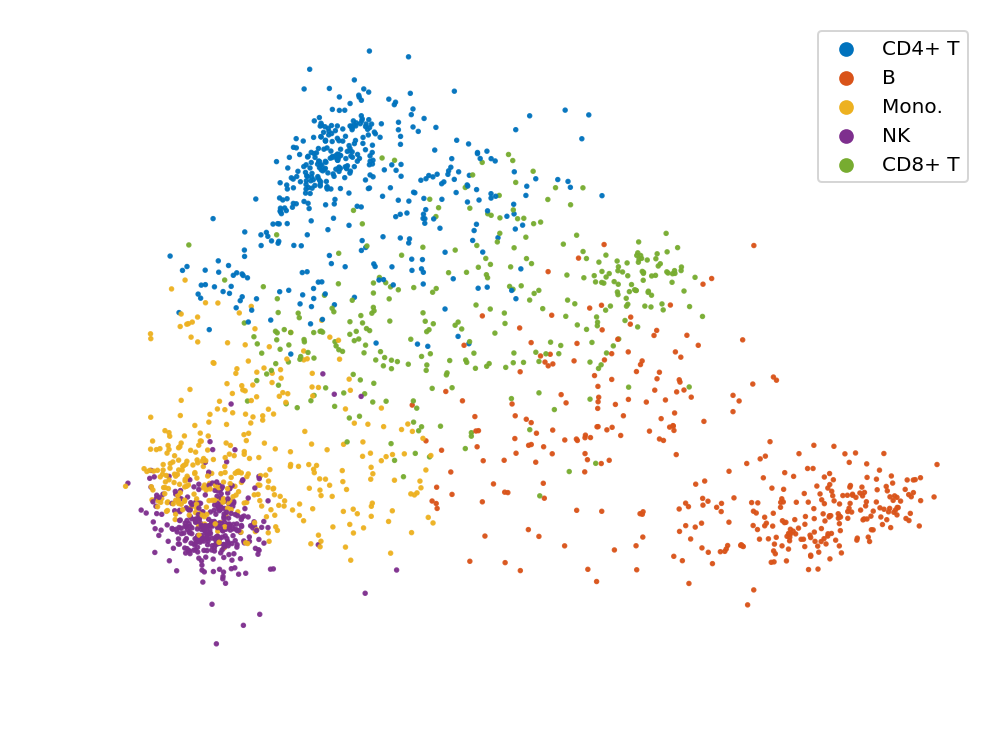

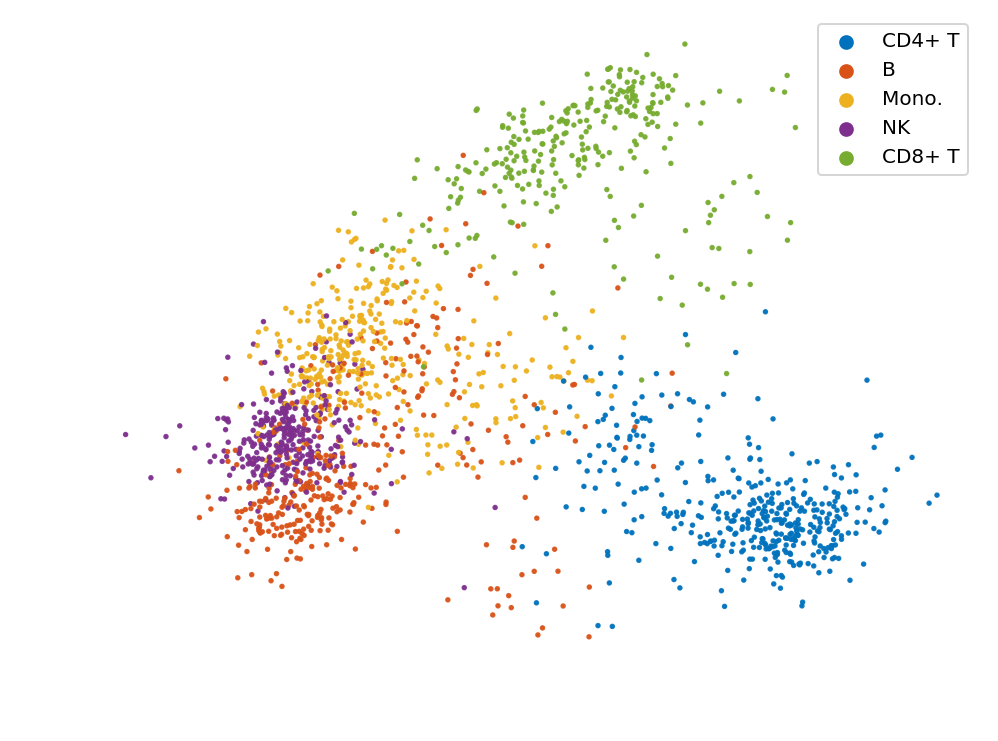

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

pca_fit = pca.fit(space)
pcs = pca.transform(space)
plt.figure(figsize=(8,6))
plt.scatter(pcs[:,0],pcs[:,1],s=3,c=COLORS[tT],alpha=0.9)
plt.xlabel('PC1')
plt.ylabel('PC2')
yl = plt.ylim()
xl = plt.xlim()
 
for i in range(NUM_CLUS):
    col=np.reshape(COLORS[i], (-1, 3))
    plt.scatter(100,100,s=0.1,c=col,alpha=1,label=lab[i])
plt.ylim(yl)
plt.xlim(xl)
plt.legend(markerscale=20)
plt.axis('off')


#####

plt.figure(figsize=(8,6))
plt.scatter(pcs[:,1],pcs[:,2],s=3,c=COLORS[tT,:],alpha=0.9)
plt.xlabel('PC2')
plt.ylabel('PC3')
yl = plt.ylim()
xl = plt.xlim()


for i in range(NUM_CLUS):
    col=np.reshape(COLORS[i], (-1, 3))
    plt.scatter(100,100,s=0.1,c=col,alpha=1,label=lab[i])
plt.ylim(yl)
plt.xlim(xl)
plt.legend(markerscale=20)
_=plt.axis('off')

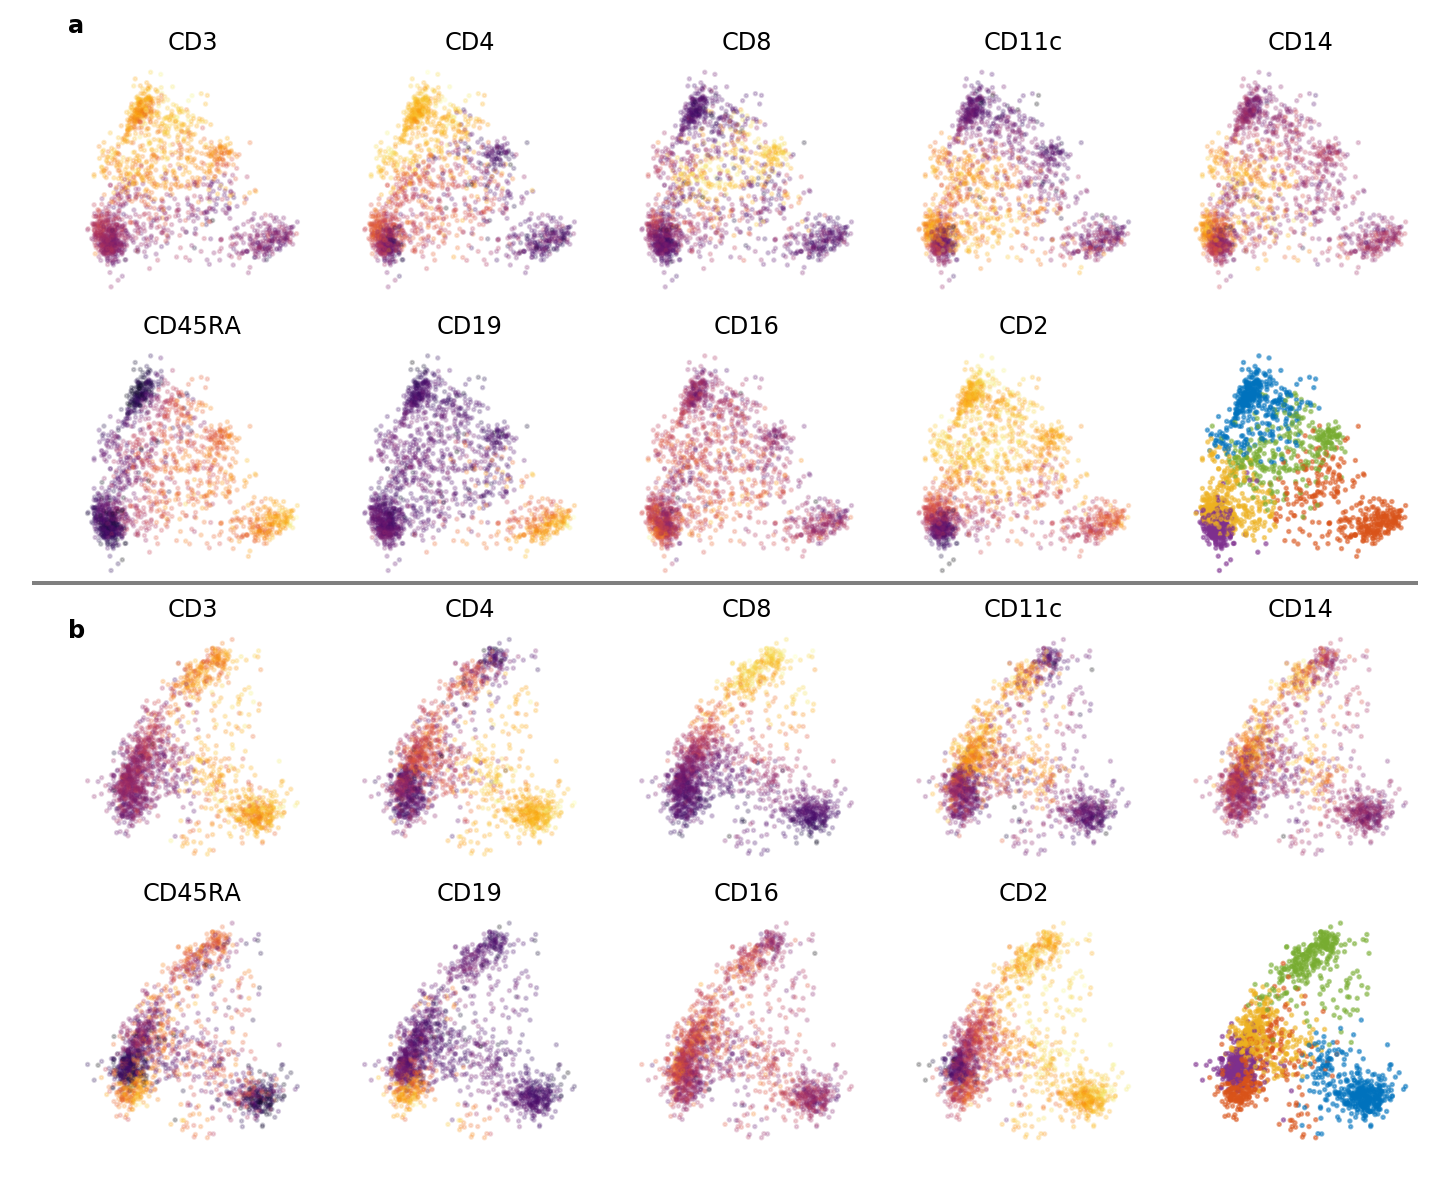

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

space = P_norm.T
AMT_CMAP = 'inferno'

pca_fit = pca.fit(space)
pcs = pca.transform(space)
f, ax = plt.subplots(nrows=4,ncols=5,figsize=(12,10))
ax = ax.flatten()

offs=5*2
    
prot_list = ['CD3','CD4','CD8','CD11c','CD14','CD45RA','CD19','CD16','CD2']

for j in range(len(prot_list)):
    prot_name=prot_list[j]
#     print(prot_name)
    ax[j].scatter(pcs[:,0],pcs[:,1],s=3,c=np.log(P[prot_genes == prot_name][0]+1),alpha=0.2,cmap=AMT_CMAP)
    ax[j].set_title(prot_name)
    
    ax[j+offs].scatter(pcs[:,1],pcs[:,2],s=3,c=np.log(P[prot_genes == prot_name][0]+1),alpha=0.2,cmap=AMT_CMAP)
    ax[j+offs].set_title(prot_name)
    
    ax[j].axis('off')
    ax[j+offs].axis('off')


ax[-1+offs].scatter(pcs[:,0],pcs[:,1],s=3,c=COLORS[tT],alpha=0.5)
ax[-1].scatter(pcs[:,1],pcs[:,2],s=3,c=COLORS[tT],alpha=0.5)
ax[-1].axis('off')
ax[-1+offs].axis('off')

f.text(0.12, 1-0.1, 'a', fontsize=12, fontweight='bold', transform=plt.gcf().transFigure)
f.text(0.12, 1-0.52, 'b', fontsize=12, fontweight='bold', transform=plt.gcf().transFigure)

l_y = 0.518
_=ax[0].plot([0.1,0.9],[l_y,l_y],c='k',alpha=0.5,linewidth=2,transform=plt.gcf().transFigure,clip_on=False)

Visualize phase portraits.

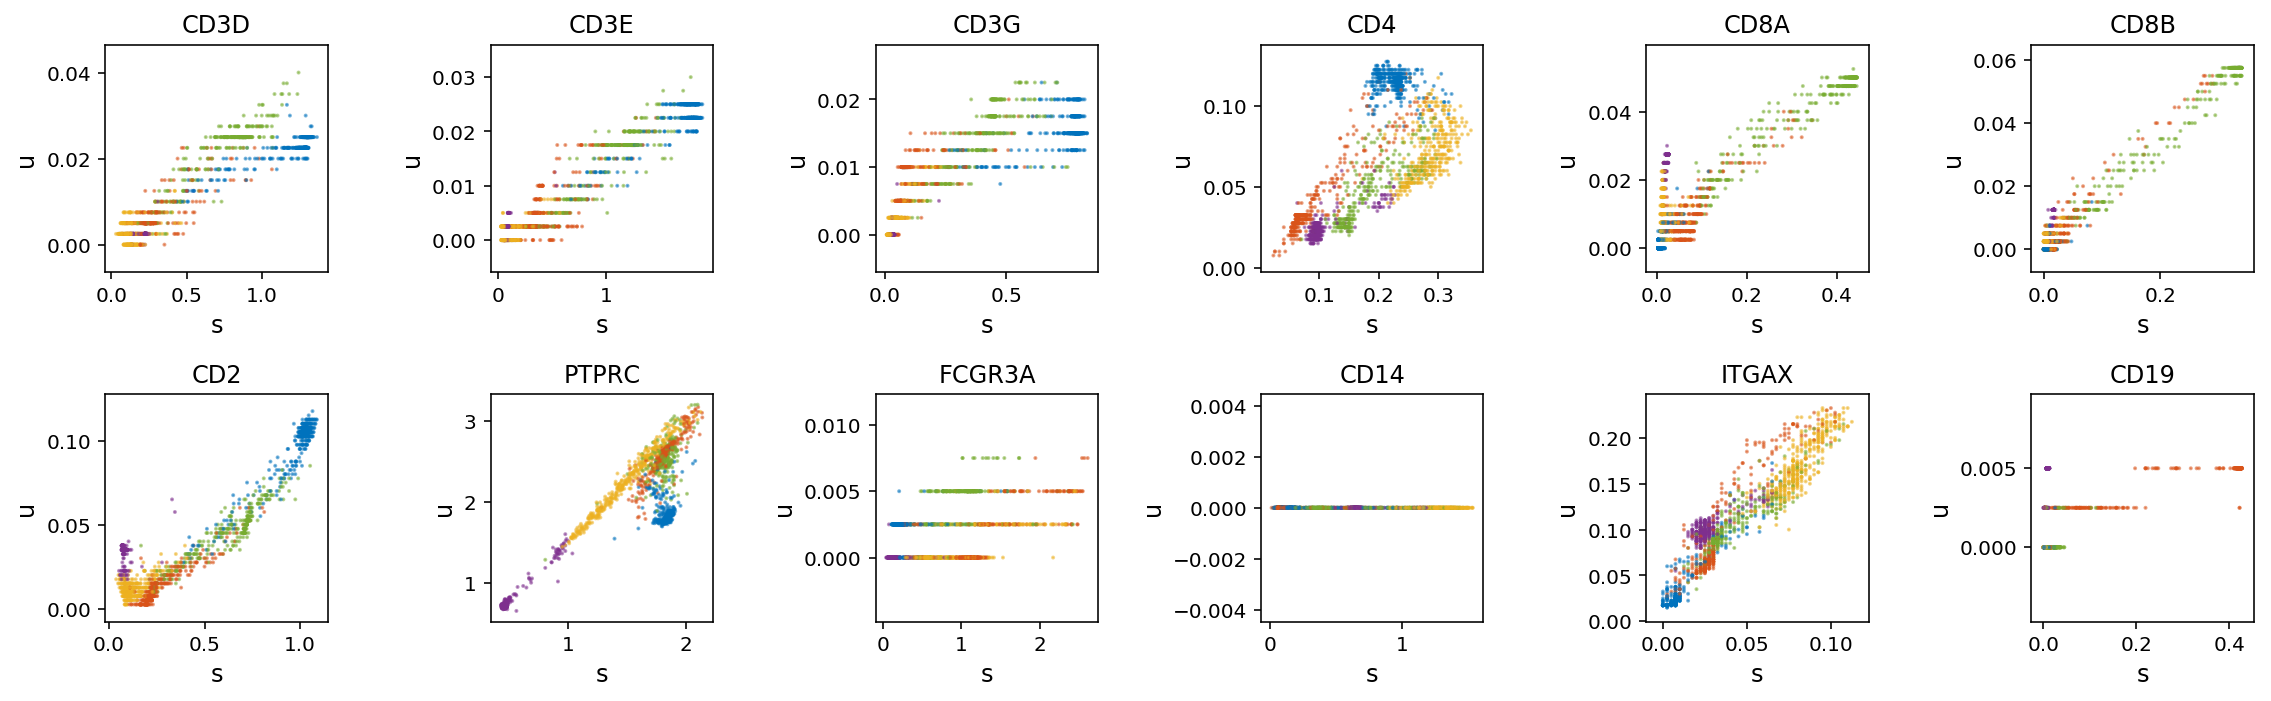

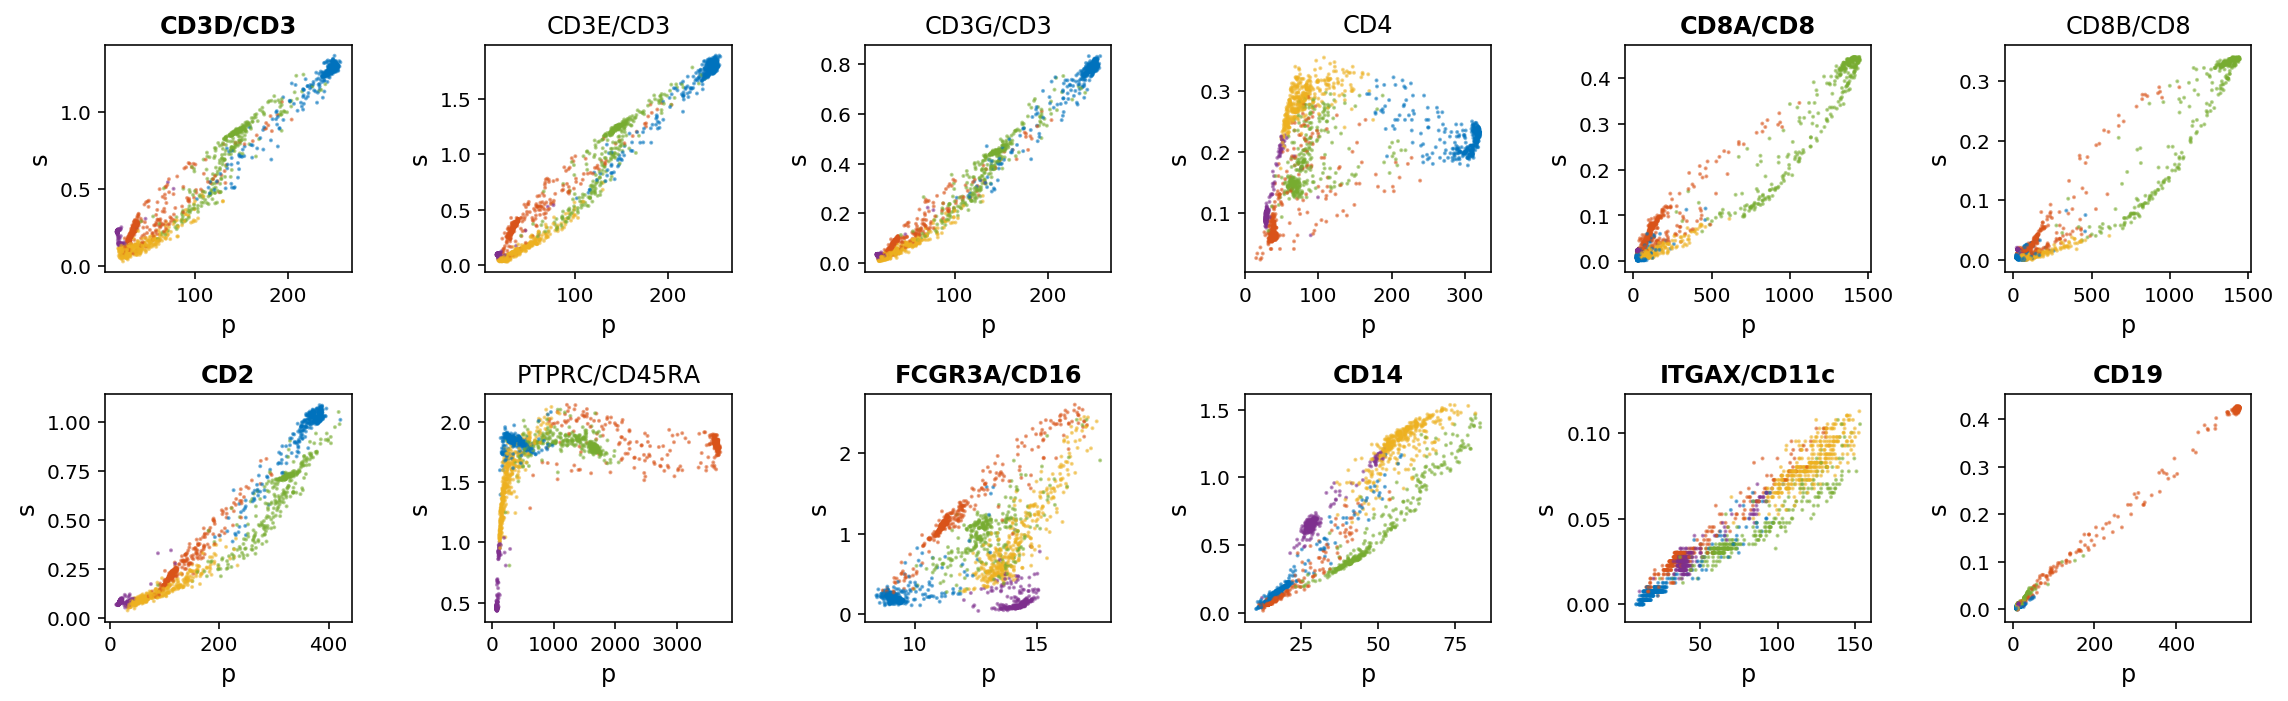

In [23]:
fig1, ax1 = plt.subplots(nrows=2,ncols=6,figsize=(16,5))
fig2, ax2 = plt.subplots(nrows=2,ncols=6,figsize=(16,5))
ax1 = ax1.flatten()
ax2 = ax2.flatten()


for targ in range(len(mrna_targets)):
    g_n = mrna_targets[targ]

#     print(g_n)
#     print(filt_genes==g_n)
    ax1[targ].scatter(Sx[filt_genes == g_n][0],Ux[filt_genes == g_n][0],s=1,c=COLORS[tT],alpha=0.5)
    
    
    prot_name = prot_dict[g_n]
    ax2[targ].scatter(Px[prot_genes == prot_name][0],Sx[filt_genes == g_n][0],s=1,c=COLORS[tT],alpha=0.5)

    ax1[targ].set_title(g_n,fontsize=12)
    ax1[targ].set_xlabel('s',fontsize=12)
    ax1[targ].set_ylabel('u',fontsize=12)
    
    if g_n==prot_name:
        title = g_n
    else:
        title = g_n+'/'+prot_name
        
    if g_n in vel_prot_gen: fw = 'bold'
    else: fw = 'normal'
    
    ax2[targ].set_title(title,fontweight=fw,fontsize=12)
    ax2[targ].set_xlabel('p',fontsize=12)
    ax2[targ].set_ylabel('s',fontsize=12)
    
fig1.tight_layout()
fig2.tight_layout()

Initialize new vlm structure for RNA velocity inference.

In [24]:
vlm_m = vcy.VelocytoLoom("velocyto_data/SPBMC/SPBMC_run3.loom")

In [25]:
vlm_m.Sx_sz = Sx
vlm_m.Ux_sz = Ux
vlm_m.Sx = Sx
vlm_m.Ux = Ux
vlm_m.S = S
vlm_m.U = U
vlm_m.S_norm = S_norm
vlm_m.ra = vlm.ra
vlm_m.ca = vlm.ca

In [26]:
vlm_m.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm_m.filter_genes(by_detection_levels=True)

In [27]:
vlm_m.fit_gammas()
vlm_m.predict_U()
vlm_m.calculate_velocity()
vlm_m.calculate_shift()
vlm_m.extrapolate_cell_at_t(delta_t=1)

In [28]:
vlm_m.perform_PCA(n_components=3)

In [29]:
hi_dim = vlm_m.Sx_sz
hi_dim_t = vlm_m.Sx_sz_t

n_neighbors = 500

embedding = vlm_m.pcs
nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=8)
nn.fit(embedding)
embedding_knn = nn.kneighbors_graph(mode="connectivity")

In [30]:
delta_hi_dim=hi_dim_t-hi_dim

psc = 1e-10
corrcoef=vcy.estimation.colDeltaCorSqrt(hi_dim, np.sqrt(np.abs(delta_hi_dim) + psc) * np.sign(delta_hi_dim), threads=8, psc=psc)


np.fill_diagonal(corrcoef, 0)

sigma_corr = 0.05
transition_prob = np.exp(corrcoef / sigma_corr) * embedding_knn.A  
transition_prob /= transition_prob.sum(1)[:, None]


unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
with np.errstate(divide='ignore', invalid='ignore'):
    unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2
    for j in range(unitary_vectors.shape[0]):
        np.fill_diagonal(unitary_vectors[j, ...], 0)  # fix nans

delta_embedding = (transition_prob * unitary_vectors).sum(2)
delta_embedding -= (embedding_knn.A * unitary_vectors).sum(2) / embedding_knn.sum(1).A.T
delta_embedding = delta_embedding.T

In [31]:
EMB_M=embedding
DEMB_M=delta_embedding
CC_M=corrcoef

In [32]:
PC_TRANSF = [1,2]
vlm_m.embedding = EMB_M[:,PC_TRANSF]
vlm_m.delta_embedding = DEMB_M[:,PC_TRANSF]
vlm_m.corrcoef = CC_M
vlm_m.ca['Clusters']=np.asarray(tT)

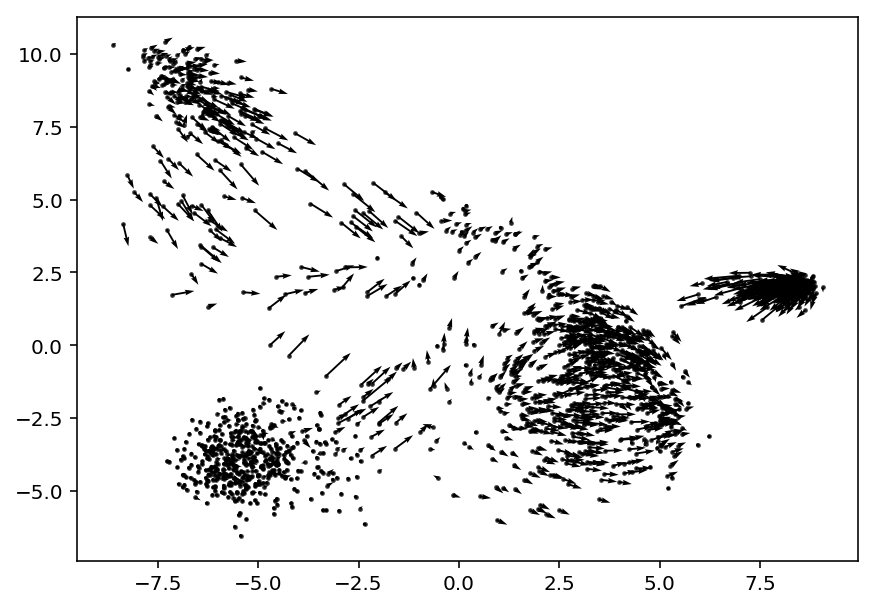

In [33]:
plt.figure(figsize=(7,5))
PC=[0,1]
# plt.quiver(pcs[:,0],pcs[:,1],vel_proj[:,0],vel_proj[:,1],pivot='tail',minlength=2)
plt.scatter(vlm_m.embedding[:, PC[0]], vlm_m.embedding[:, PC[1]],s=2,c='k',alpha=0.7)
plt.quiver(vlm_m.embedding[:,PC[0]],vlm_m.embedding[:,PC[1]],vlm_m.delta_embedding[:,PC[0]],vlm_m.delta_embedding[:,PC[1]],pivot='tail',minlength=2)

In [34]:
vlm_m.calculate_grid_arrows('embedding',steps=(20,20,20),n_neighbors=100)

In [35]:
vlm_m.colorandum= np.ones((vlm_m.embedding.shape[0], 4))

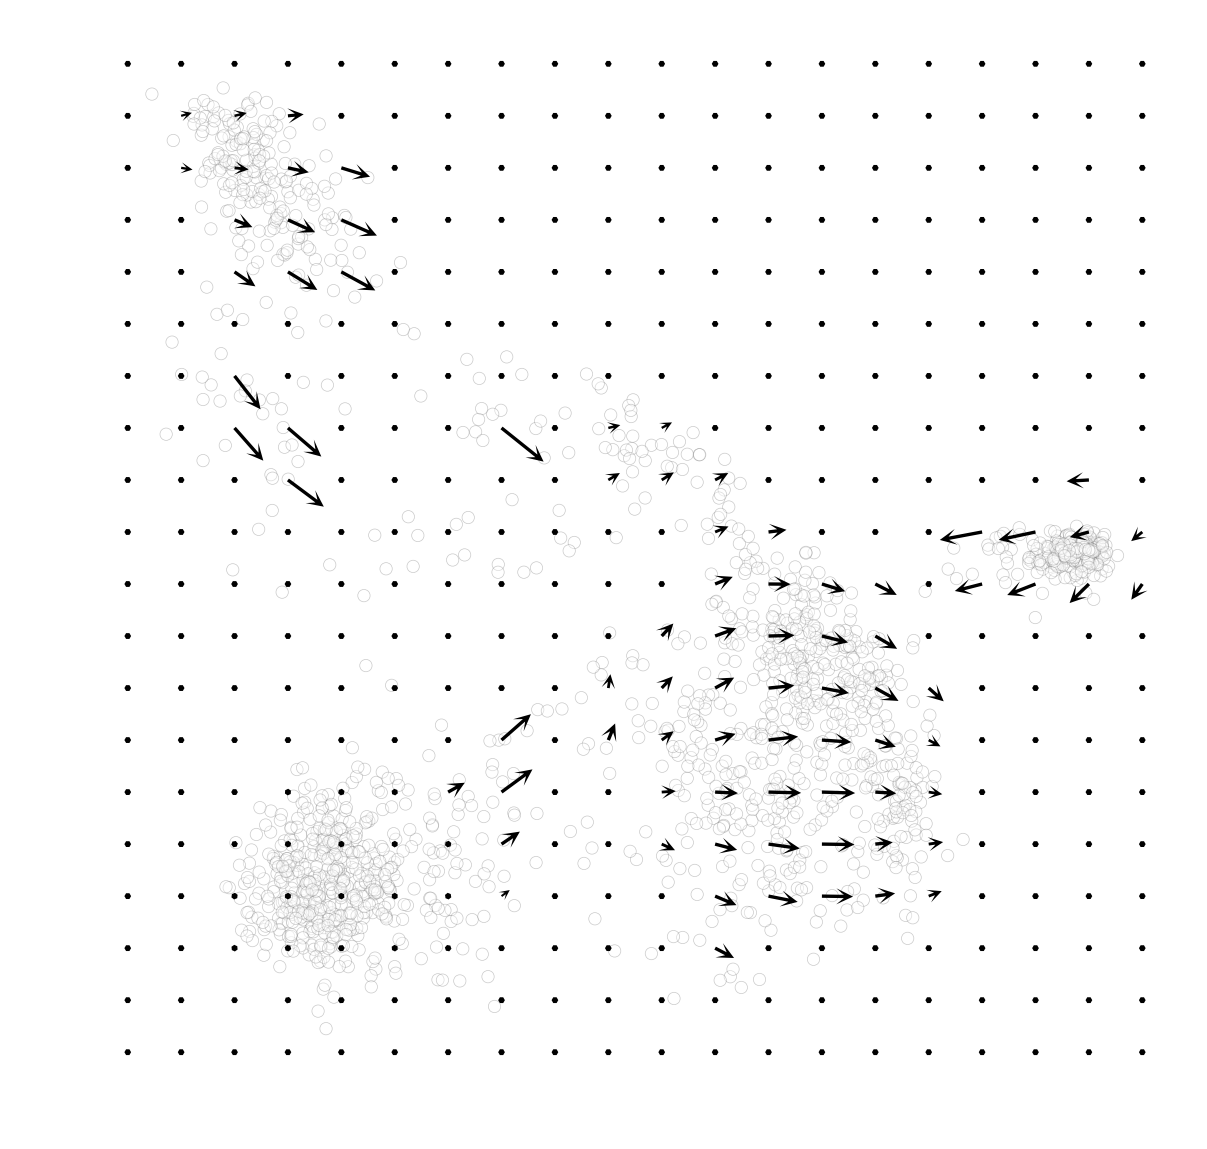

In [36]:
plt.figure(None,(10,10))
vlm_m.plot_grid_arrows(quiver_scale=0.6,
                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=4, angles='xy', scale_units='xy',
                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=2,
                    plot_random=False, scale_type="absolute",plot_dots=True)


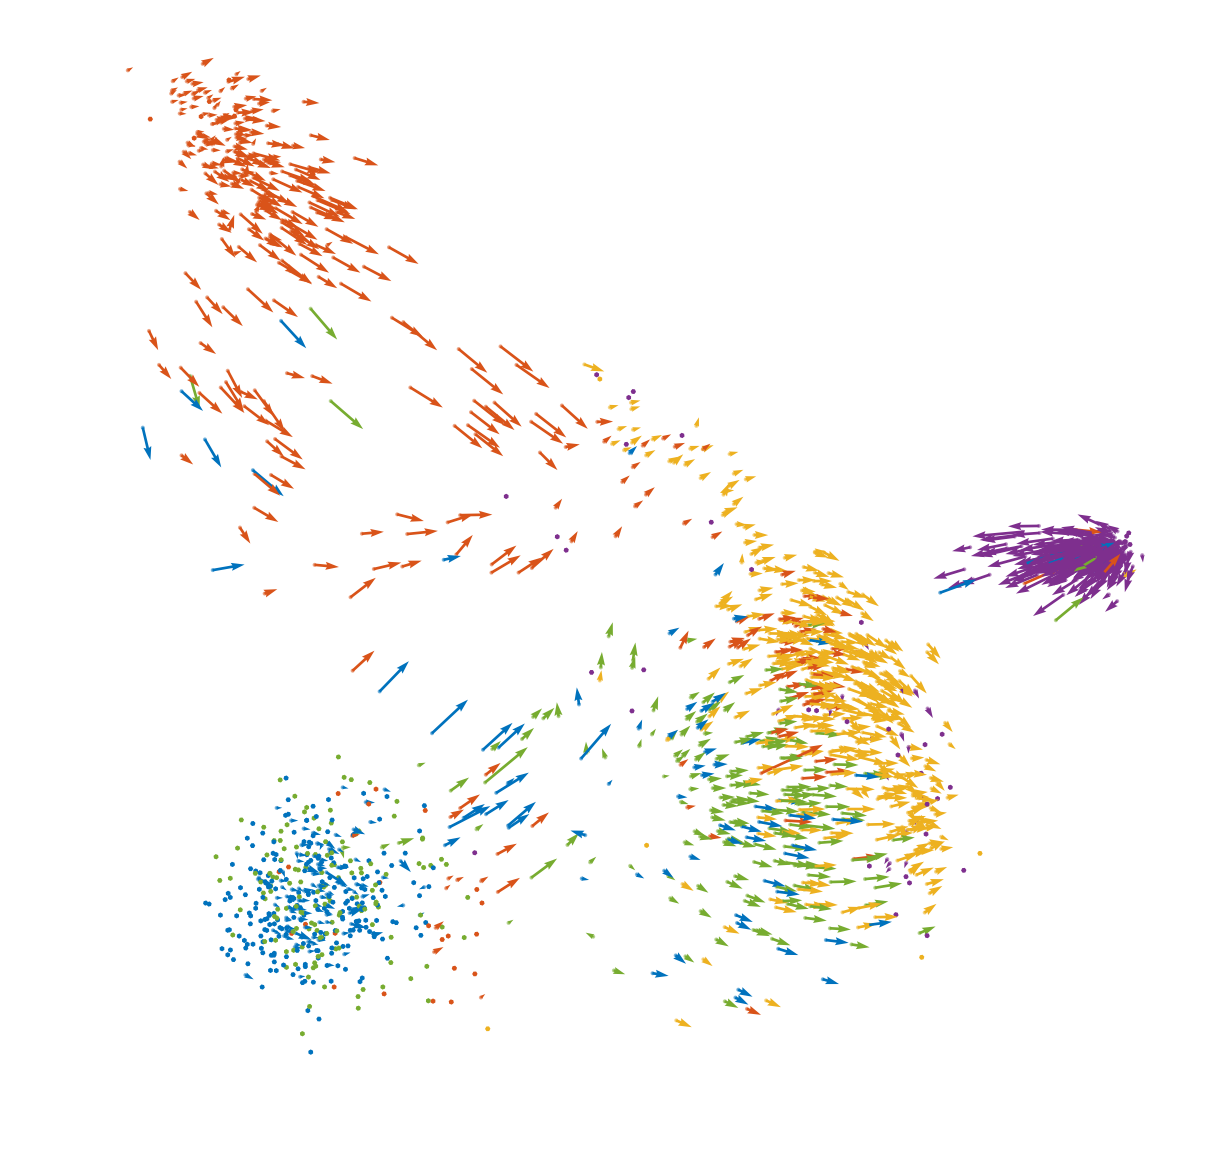

In [37]:
plt.figure(figsize=(10,10))

PC = [0,1]
plt.scatter(vlm_m.embedding[:, 0], vlm_m.embedding[:, 1],c=COLORS[tT],alpha=0.5,s=1)
plt.quiver(vlm_m.embedding[:,0],vlm_m.embedding[:,1],
           vlm_m.delta_embedding[:,0],vlm_m.delta_embedding[:,1],color=COLORS[tT],
           pivot='tail',minlength=2)
_ = plt.axis('off')

Plot cell type-specific velocities.

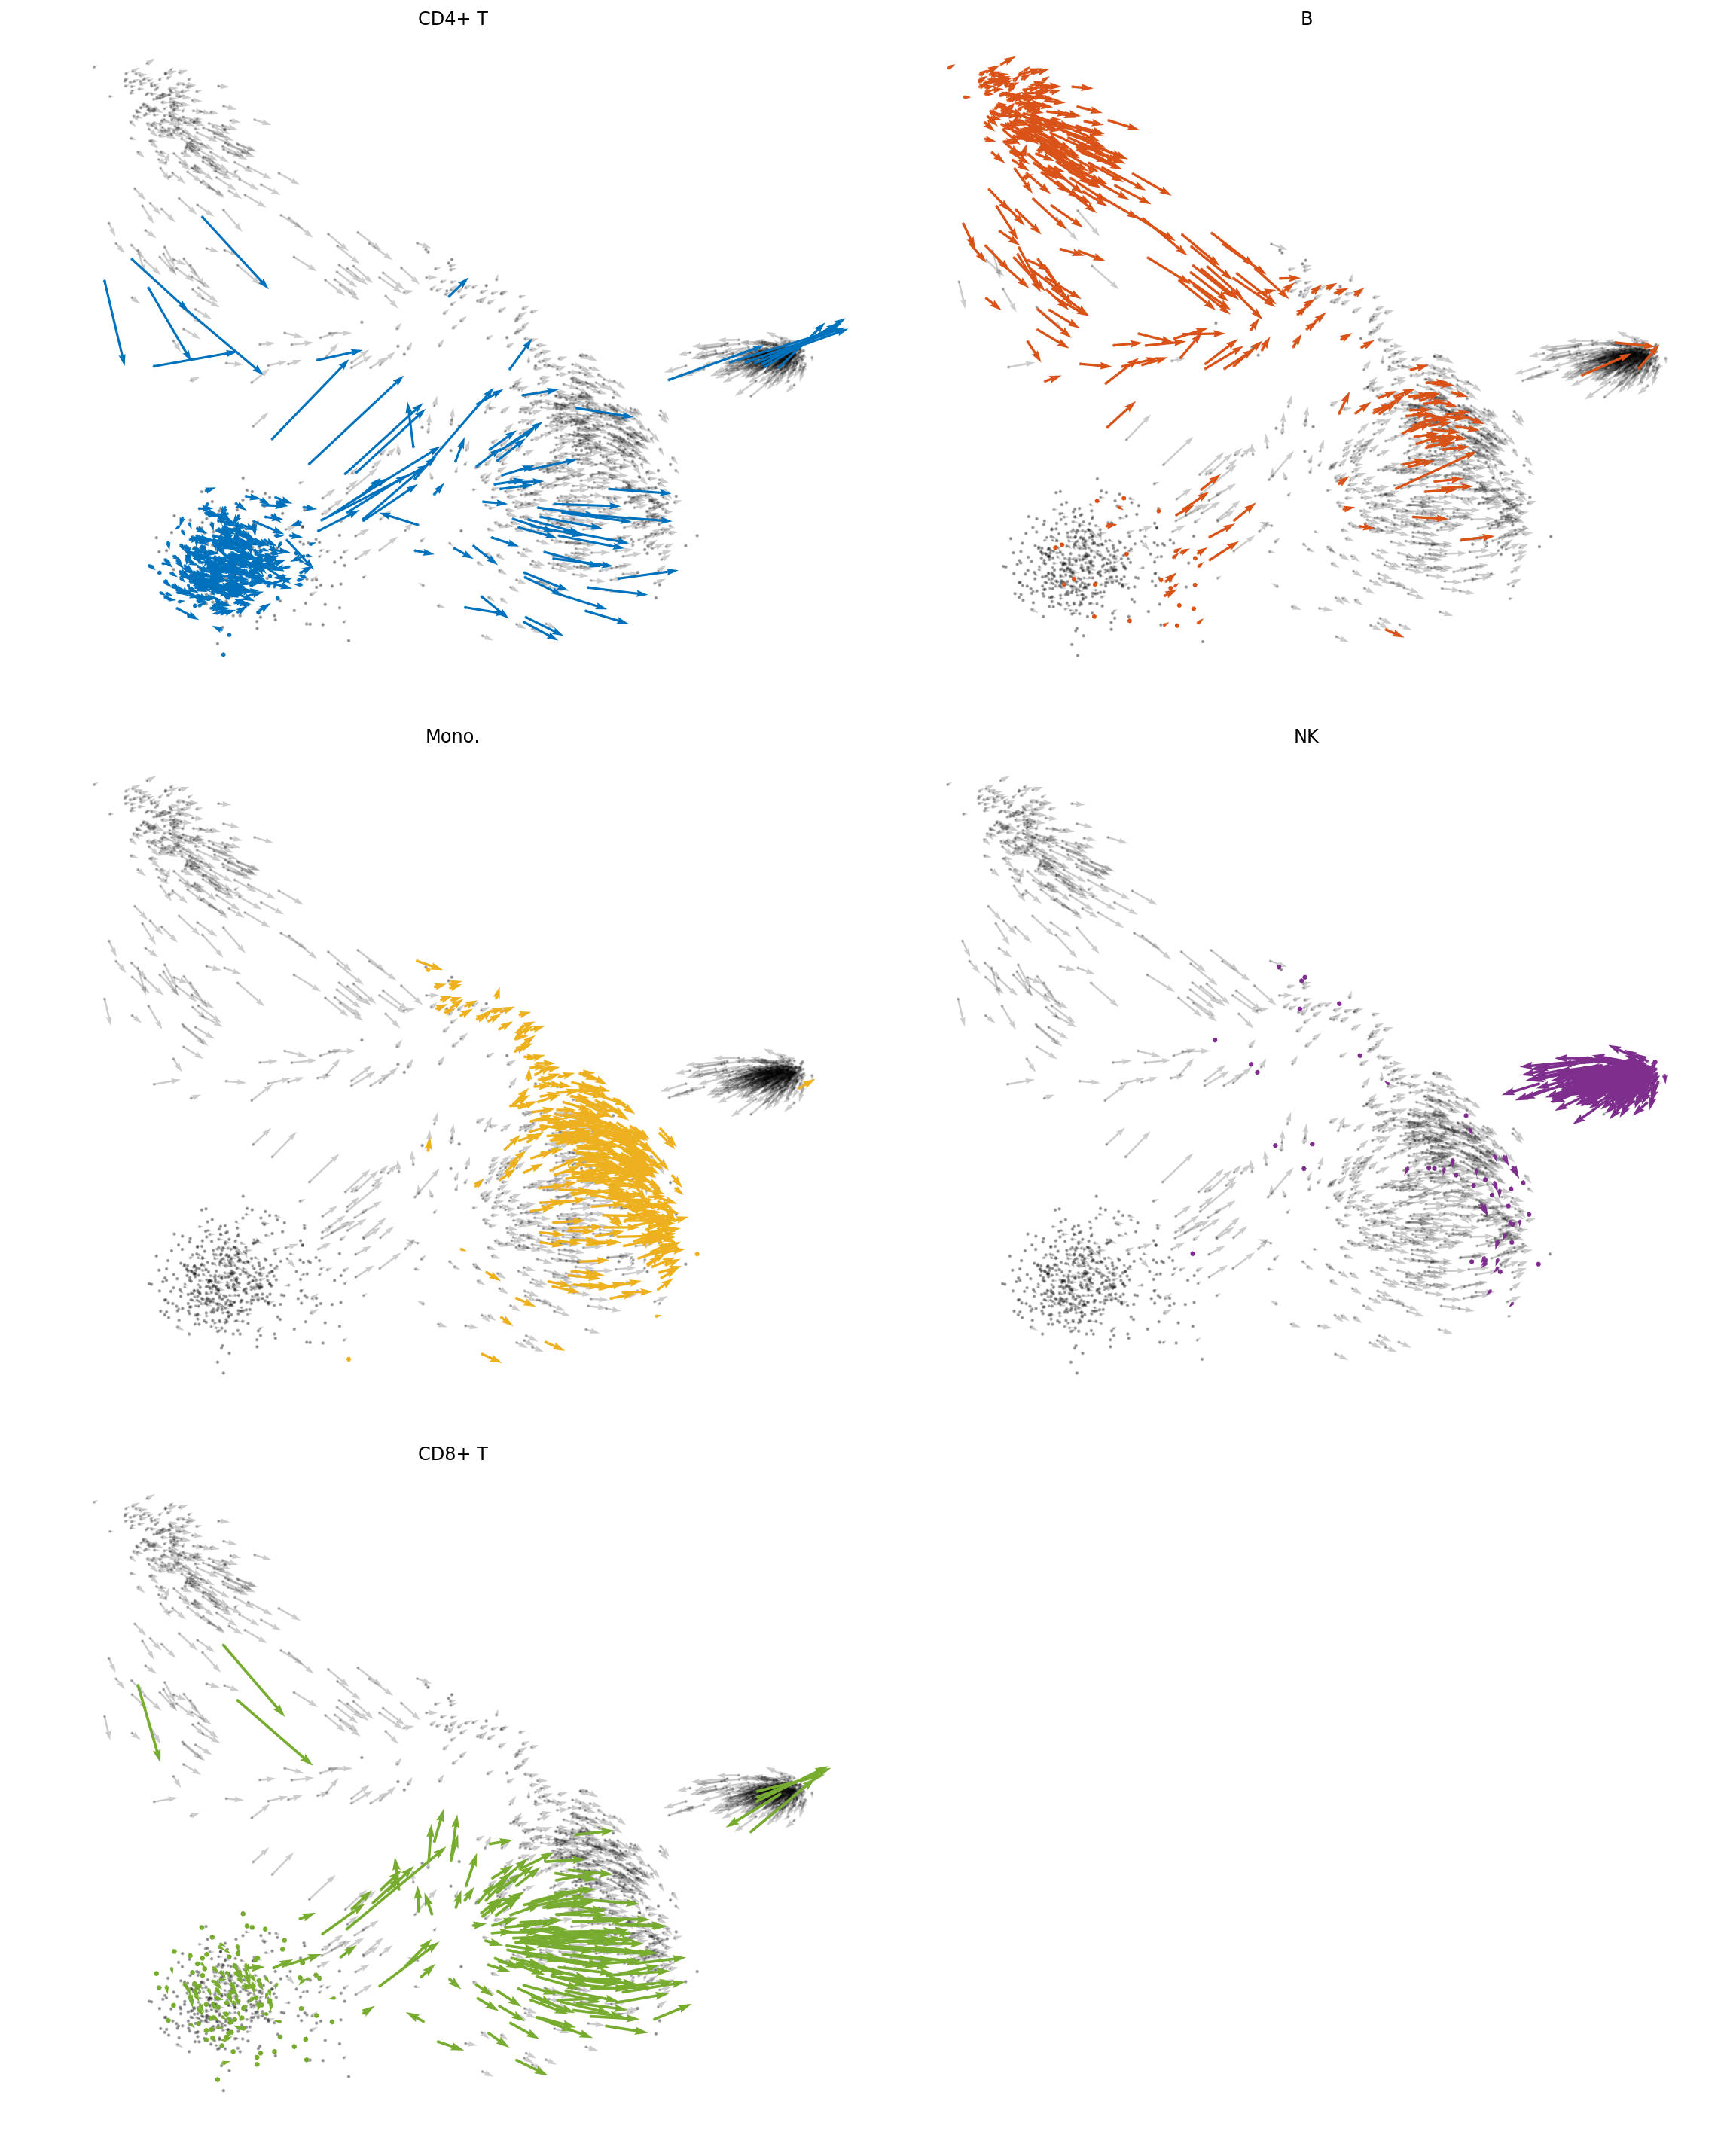

In [38]:
fig_1, ax_1 = plt.subplots(nrows=3,ncols=2,figsize=(16,20))
ax_1 = ax_1.flatten()

PC = [0,1]
cc = vlm_m.ca['Clusters']
for j in range(NUM_CLUS):

    nC = np.sum(cc==j)
    col=np.matlib.repmat(COLORS[j],nC,1)
    gray_col=np.matlib.repmat([0,0,0],len(cc)-nC,1)

    ax_1[j].scatter(vlm_m.embedding[cc!=j, 0], vlm_m.embedding[cc!=j, 1],c=gray_col,alpha=0.2,s=1)
    ax_1[j].quiver(vlm_m.embedding[cc!=j,0],vlm_m.embedding[cc!=j,1],
               vlm_m.delta_embedding[cc!=j,0],vlm_m.delta_embedding[cc!=j,1],
               color=gray_col,pivot='tail',minlength=2,alpha=0.2)
    
    ax_1[j].scatter(vlm_m.embedding[cc==j, 0], vlm_m.embedding[cc==j, 1],c=col,alpha=0.8,s=1)
    ax_1[j].quiver(vlm_m.embedding[cc==j,0],vlm_m.embedding[cc==j,1],
               vlm_m.delta_embedding[cc==j,0],vlm_m.delta_embedding[cc==j,1],
               color=col,pivot='tail',minlength=2)
    
    
    ax_1[j].axis('off')
    ax_1[j].set_title(lab[j])

ax_1[-1].axis('off')
fig_1.tight_layout()

Identify and extract protein data.

In [39]:
prot_ind = [np.where(prot_genes==x)[0][0] for x in vel_prot_prot]

In [40]:
rna_ind = [np.where(filt_genes==x)[0][0] for x in vel_prot_gen]

In [41]:
S_pv = S[rna_ind]
Sx_pv = Sx[rna_ind]
P_pv = P[prot_ind]
P_med_pv = P_med[prot_ind]
Px_pv = Px[prot_ind]
P_norm_pv = P_norm[prot_ind]

In [42]:
vlm_p = vcy.VelocytoLoom("velocyto_data/SPBMC/SPBMC_run3.loom")

In [43]:
vlm_p.Sx_sz = Px_pv
vlm_p.Ux_sz = Sx_pv
vlm_p.Sx = Px_pv
vlm_p.Ux = Sx_pv
vlm_p.S = P_pv
vlm_p.U = S_pv
vlm_p.S_norm = P_norm_pv
vlm_p.P_med = P_med_pv
vlm_p.ra['Gene'] = vel_prot_prot
vlm_p.pcs = vlm_m.pcs
vlm_p.ca['Clusters']=tag_list
vlm_p.lab=lab
vlm_p.COLORS=COLORS
vlm_p.tT = tT

In [44]:
vlm_p.fit_gammas()
vlm_p.predict_U()

In [45]:
a=vlm_p.Ux_sz - vlm_p.Upred

In [46]:
vlm_p.velocity=a*np.matlib.repmat(vlm_p.P_med,a.shape[1],1).T

In [47]:
vlm_p.calculate_shift()
vlm_p.extrapolate_cell_at_t(delta_t=1)

In [48]:
hi_dim = vlm_p.Sx_sz
hi_dim_t = vlm_p.Sx_sz_t

n_neighbors = 500-1

embedding = vlm_m.pcs
nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=8)
nn.fit(embedding)
embedding_knn = nn.kneighbors_graph(mode="connectivity")


In [49]:
delta_hi_dim=hi_dim_t-hi_dim

psc = 1e-10
corrcoef=vcy.estimation.colDeltaCorSqrt(hi_dim, np.sqrt(np.abs(delta_hi_dim) + psc) * np.sign(delta_hi_dim), threads=8, psc=psc)

np.fill_diagonal(corrcoef, 0)

sigma_corr = 0.05
transition_prob = np.exp(corrcoef / sigma_corr) * embedding_knn.A  
transition_prob /= transition_prob.sum(1)[:, None]


unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
with np.errstate(divide='ignore', invalid='ignore'):
    unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2
    for j in range(unitary_vectors.shape[0]):
        np.fill_diagonal(unitary_vectors[j, ...], 0)  # fix nans

delta_embedding = (transition_prob * unitary_vectors).sum(2)
delta_embedding -= (embedding_knn.A * unitary_vectors).sum(2) / embedding_knn.sum(1).A.T
delta_embedding = delta_embedding.T

In [50]:
EMB_P=embedding
DEMB_P=delta_embedding
CC_P=corrcoef

In [51]:
PC_TRANSF = [1,2]
vlm_p.embedding = EMB_P[:,PC_TRANSF]
vlm_p.delta_embedding = DEMB_P[:,PC_TRANSF]
vlm_p.corrcoef = CC_P

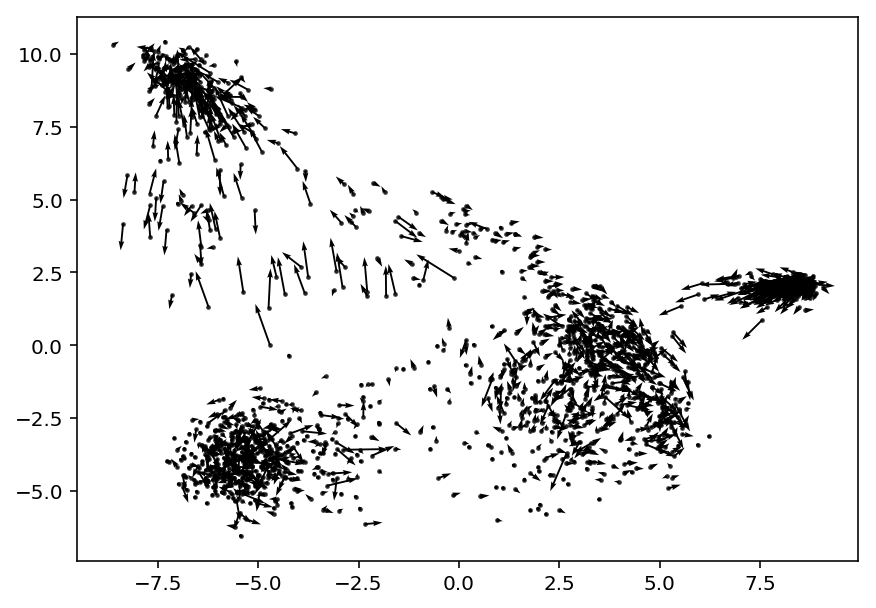

In [52]:
plt.figure(figsize=(7,5))
PC=[0,1]
plt.scatter(vlm_p.embedding[:, PC[0]], vlm_p.embedding[:, PC[1]],s=2,c='k',alpha=0.7)
plt.quiver(vlm_p.embedding[:,PC[0]],vlm_p.embedding[:,PC[1]],vlm_p.delta_embedding[:,PC[0]],vlm_p.delta_embedding[:,PC[1]],pivot='tail',minlength=2)

In [53]:
vlm_p.calculate_grid_arrows('embedding',steps=(20,20,20),n_neighbors=200)

In [54]:
vlm_p.colorandum= np.ones((vlm_p.embedding.shape[0], 4))

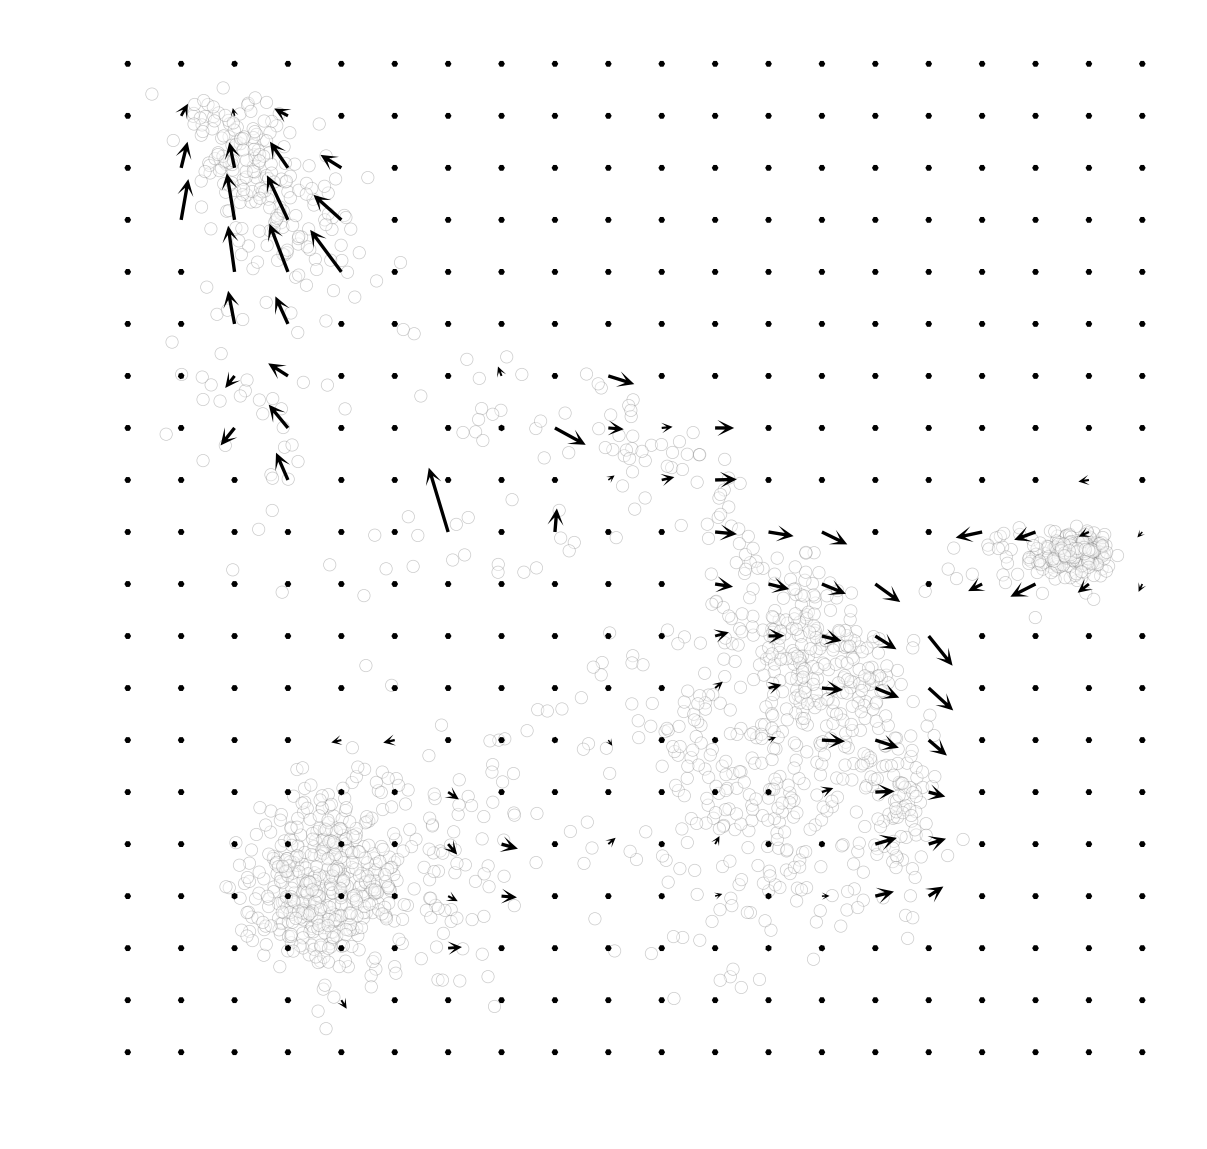

In [55]:
plt.figure(None,(10,10))
vlm_p.plot_grid_arrows(quiver_scale=0.6,
                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=3, angles='xy', scale_units='xy',
                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=2,
                    plot_random=False, scale_type="absolute",plot_dots=True)


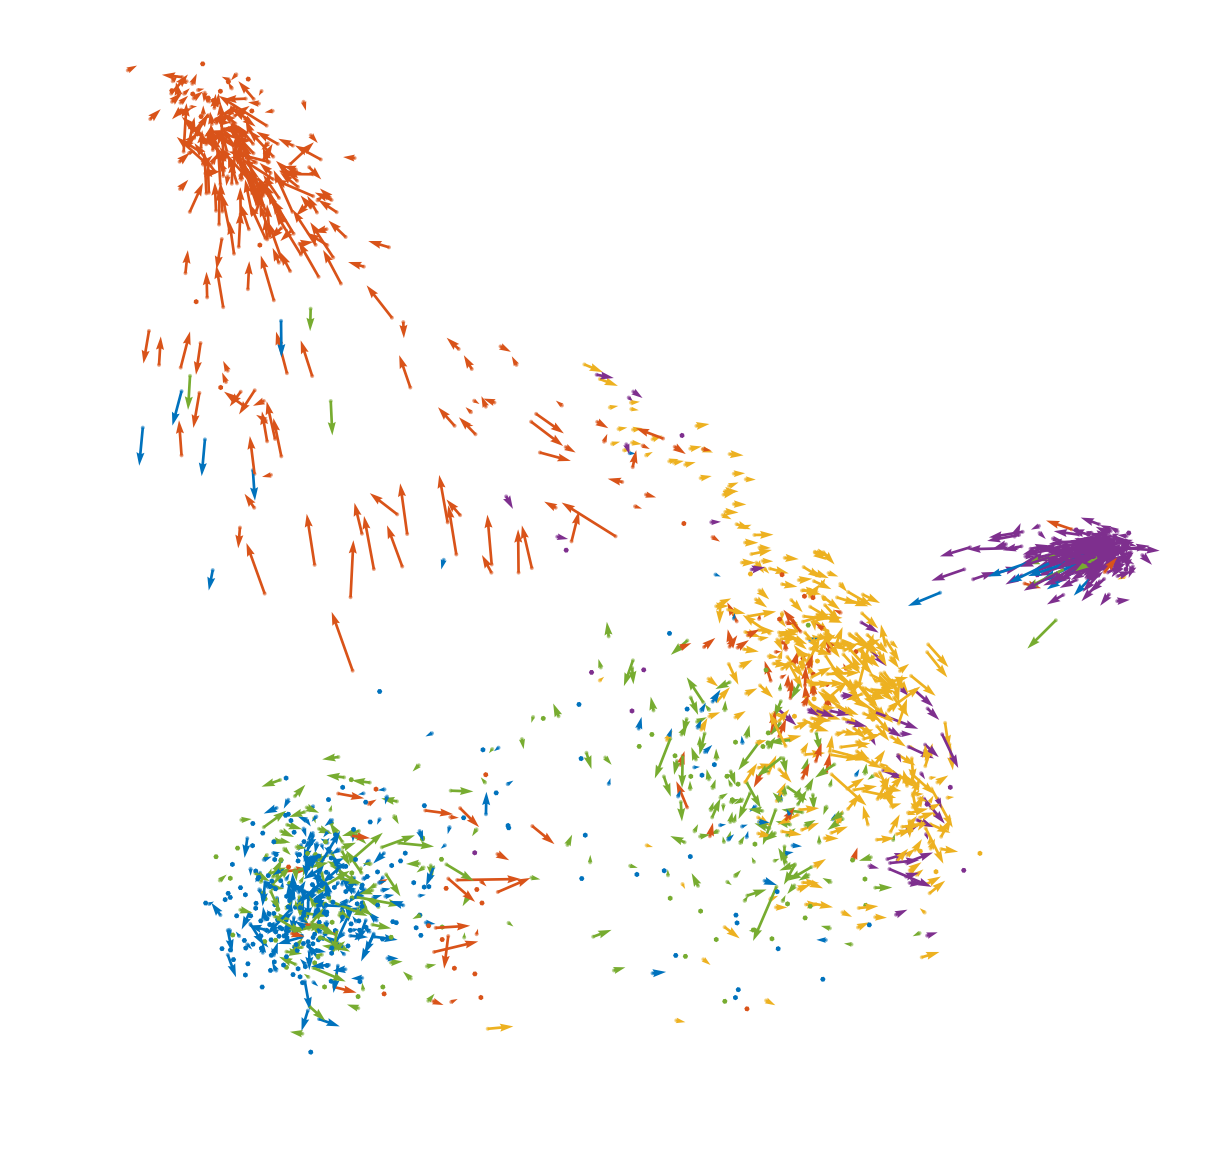

In [56]:
   
plt.figure(figsize=(10,10))

PC = [0,1]
plt.scatter(vlm_p.embedding[:, 0], vlm_p.embedding[:, 1],c=COLORS[tT],alpha=0.5,s=1)
plt.quiver(vlm_p.embedding[:,0],vlm_p.embedding[:,1],
           vlm_p.delta_embedding[:,0],vlm_p.delta_embedding[:,1],color=COLORS[tT],
           pivot='tail',minlength=2)

_=plt.axis('off')

Plot cell type-specific protein velocities.

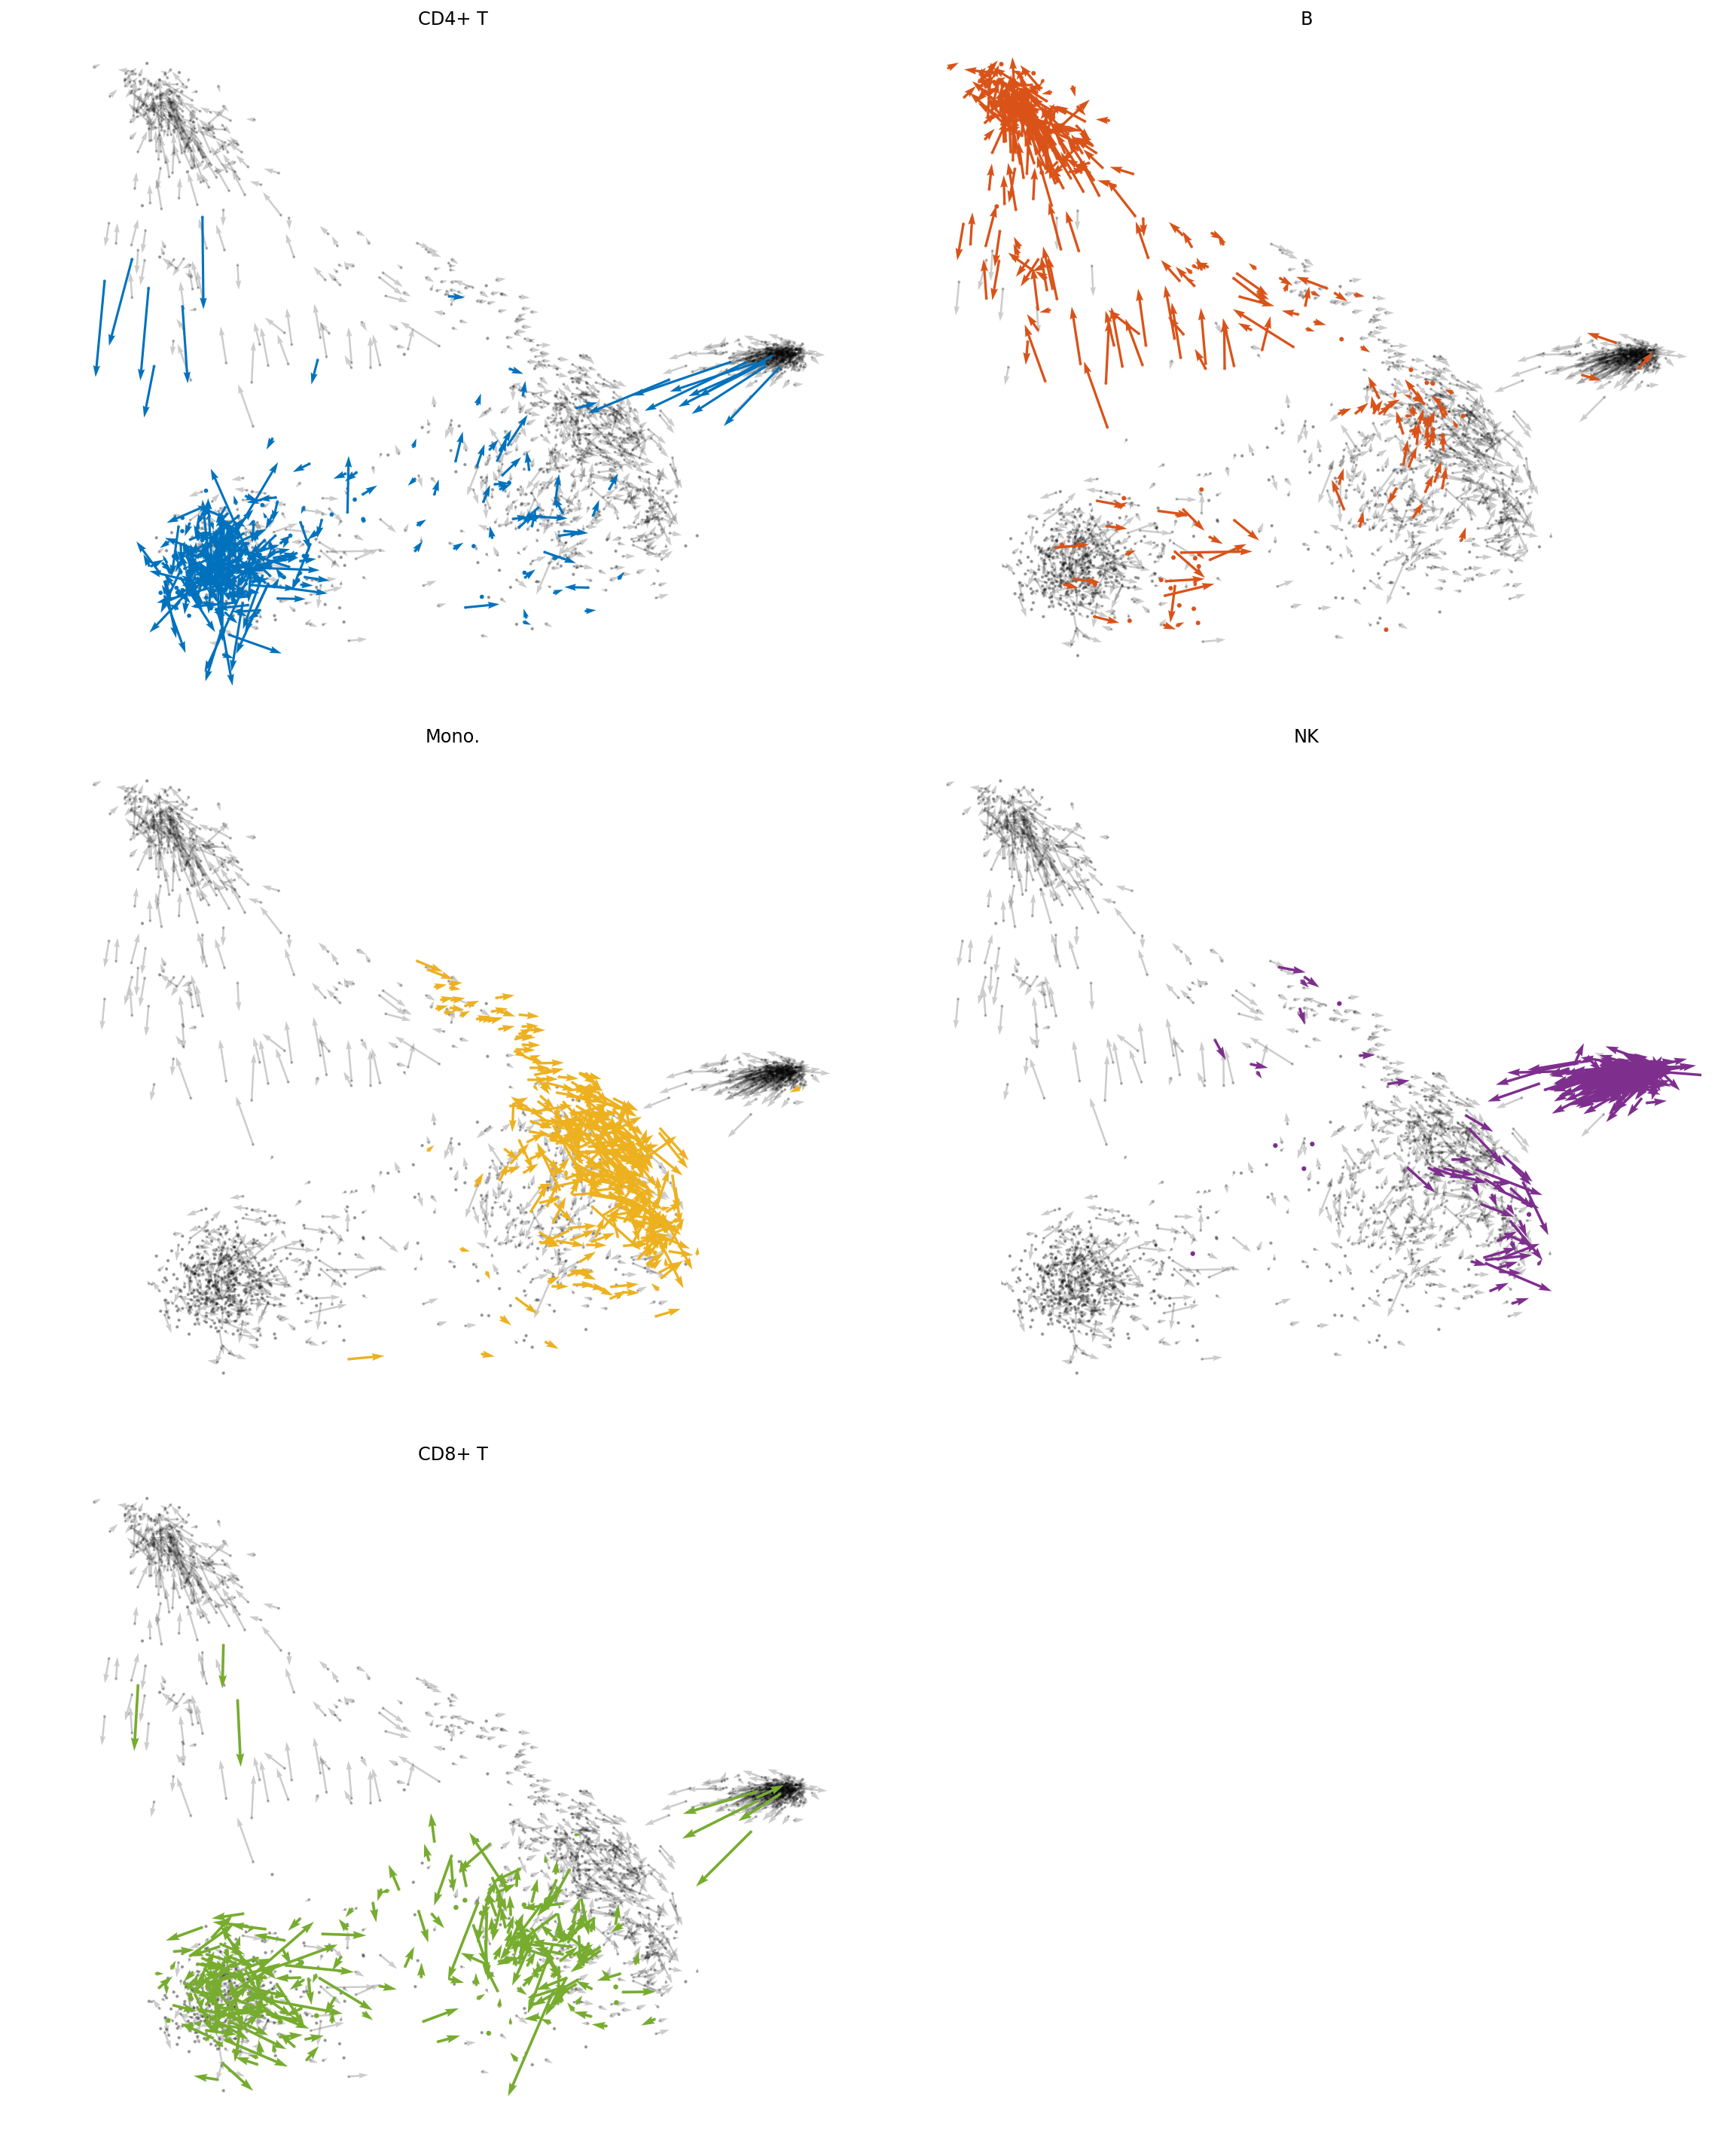

In [57]:
fig_1, ax_1 = plt.subplots(nrows=3,ncols=2,figsize=(16,20))
ax_1 = ax_1.flatten()

PC = [0,1]
cc = vlm_p.ca['Clusters']
for j in range(NUM_CLUS):
#     print(cc==j)
    nC = np.sum(cc==j)
    col=np.matlib.repmat(COLORS[j],nC,1)
    gray_col=np.matlib.repmat([0,0,0],len(cc)-nC,1)

    ax_1[j].scatter(vlm_p.embedding[cc!=j, 0], vlm_p.embedding[cc!=j, 1],c=gray_col,alpha=0.2,s=1)
    ax_1[j].quiver(vlm_p.embedding[cc!=j,0],vlm_p.embedding[cc!=j,1],
               vlm_p.delta_embedding[cc!=j,0],vlm_p.delta_embedding[cc!=j,1],
               color=gray_col,pivot='tail',minlength=2,alpha=0.2)
    
    ax_1[j].scatter(vlm_p.embedding[cc==j, 0], vlm_p.embedding[cc==j, 1],c=col,alpha=0.8,s=1)
    ax_1[j].quiver(vlm_p.embedding[cc==j,0],vlm_p.embedding[cc==j,1],
               vlm_p.delta_embedding[cc==j,0],vlm_p.delta_embedding[cc==j,1],
               color=col,pivot='tail',minlength=2)
    
    
    ax_1[j].axis('off')
    ax_1[j].set_title(lab[j])

ax_1[-1].axis('off')
fig_1.tight_layout()

Filter and plot acceleration plots.

In [58]:
min_mass_m=4
mass_filter_m = vlm_m.total_p_mass < min_mass_m
XYM, UVM = np.copy(vlm_m.flow_grid), np.copy(vlm_m.flow_norm)
XYM[mass_filter_m,:] = 0
UVM[mass_filter_m,:] = 0

min_mass_p=3
mass_filter_p = vlm_p.total_p_mass < min_mass_m
XYP, UVP = np.copy(vlm_p.flow_grid), np.copy(vlm_p.flow_norm)
XYP[mass_filter_p,:] = 0
UVP[mass_filter_p,:] = 0

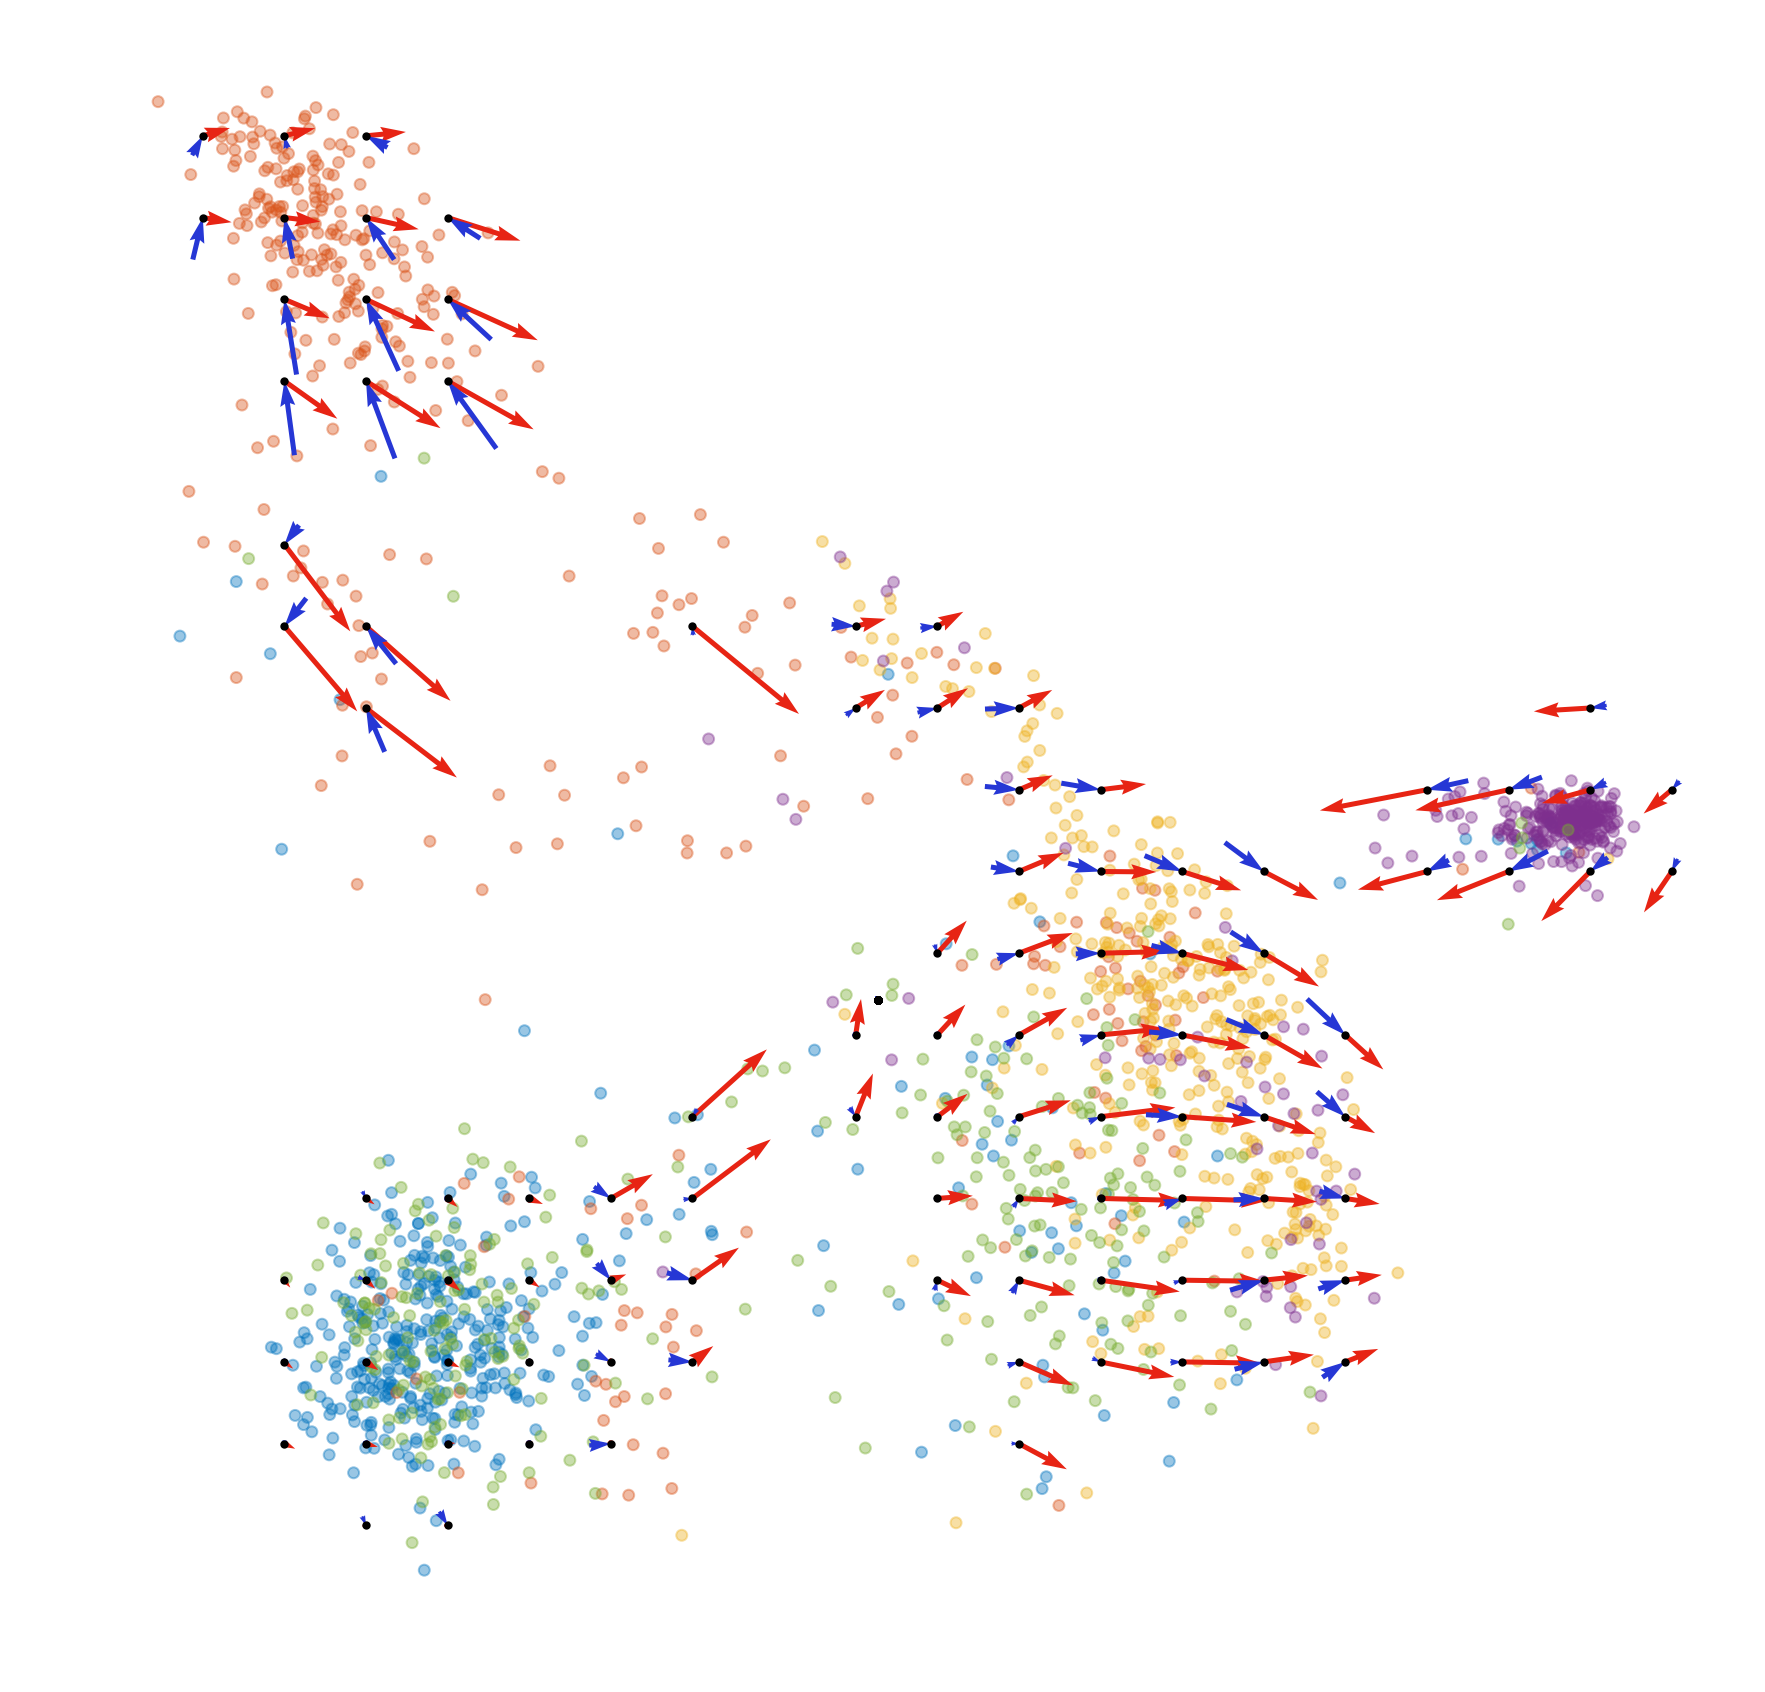

In [63]:
plt.figure(figsize=(15,15))

r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]


cc = vlm_p.ca['Clusters']
COLORS=vlm_p.COLORS
for j in range(NUM_CLUS):
#     print(cc==j)
    nC = np.sum(cc==j)
    col=np.matlib.repmat(COLORS[j],nC,1)
    plt.scatter(vlm_p.embedding[cc==j, 0], vlm_p.embedding[cc==j, 1],c=col,alpha=0.4,s=30)

    
plt.quiver(XYM[:, 0], XYM[:, 1], UVM[:, 0], UVM[:, 1],
           scale=0.6, zorder=20000, **{"angles": 'xy', "scale_units": 'xy', "minlength": 1.5},color=r_rnav)

plt.quiver(XYP[:, 0], XYP[:, 1], UVP[:, 0], UVP[:, 1],
           scale=0.6, zorder=20000, **{"angles": 'xy', "scale_units": 'xy', "minlength": 1.5, "pivot": 'tip'},
           color=b_protv)
plt.scatter(XYM[:, 0], XYM[:, 1],c='k',s=10,zorder=30000)

_=plt.axis('off')

In [60]:
import bezier

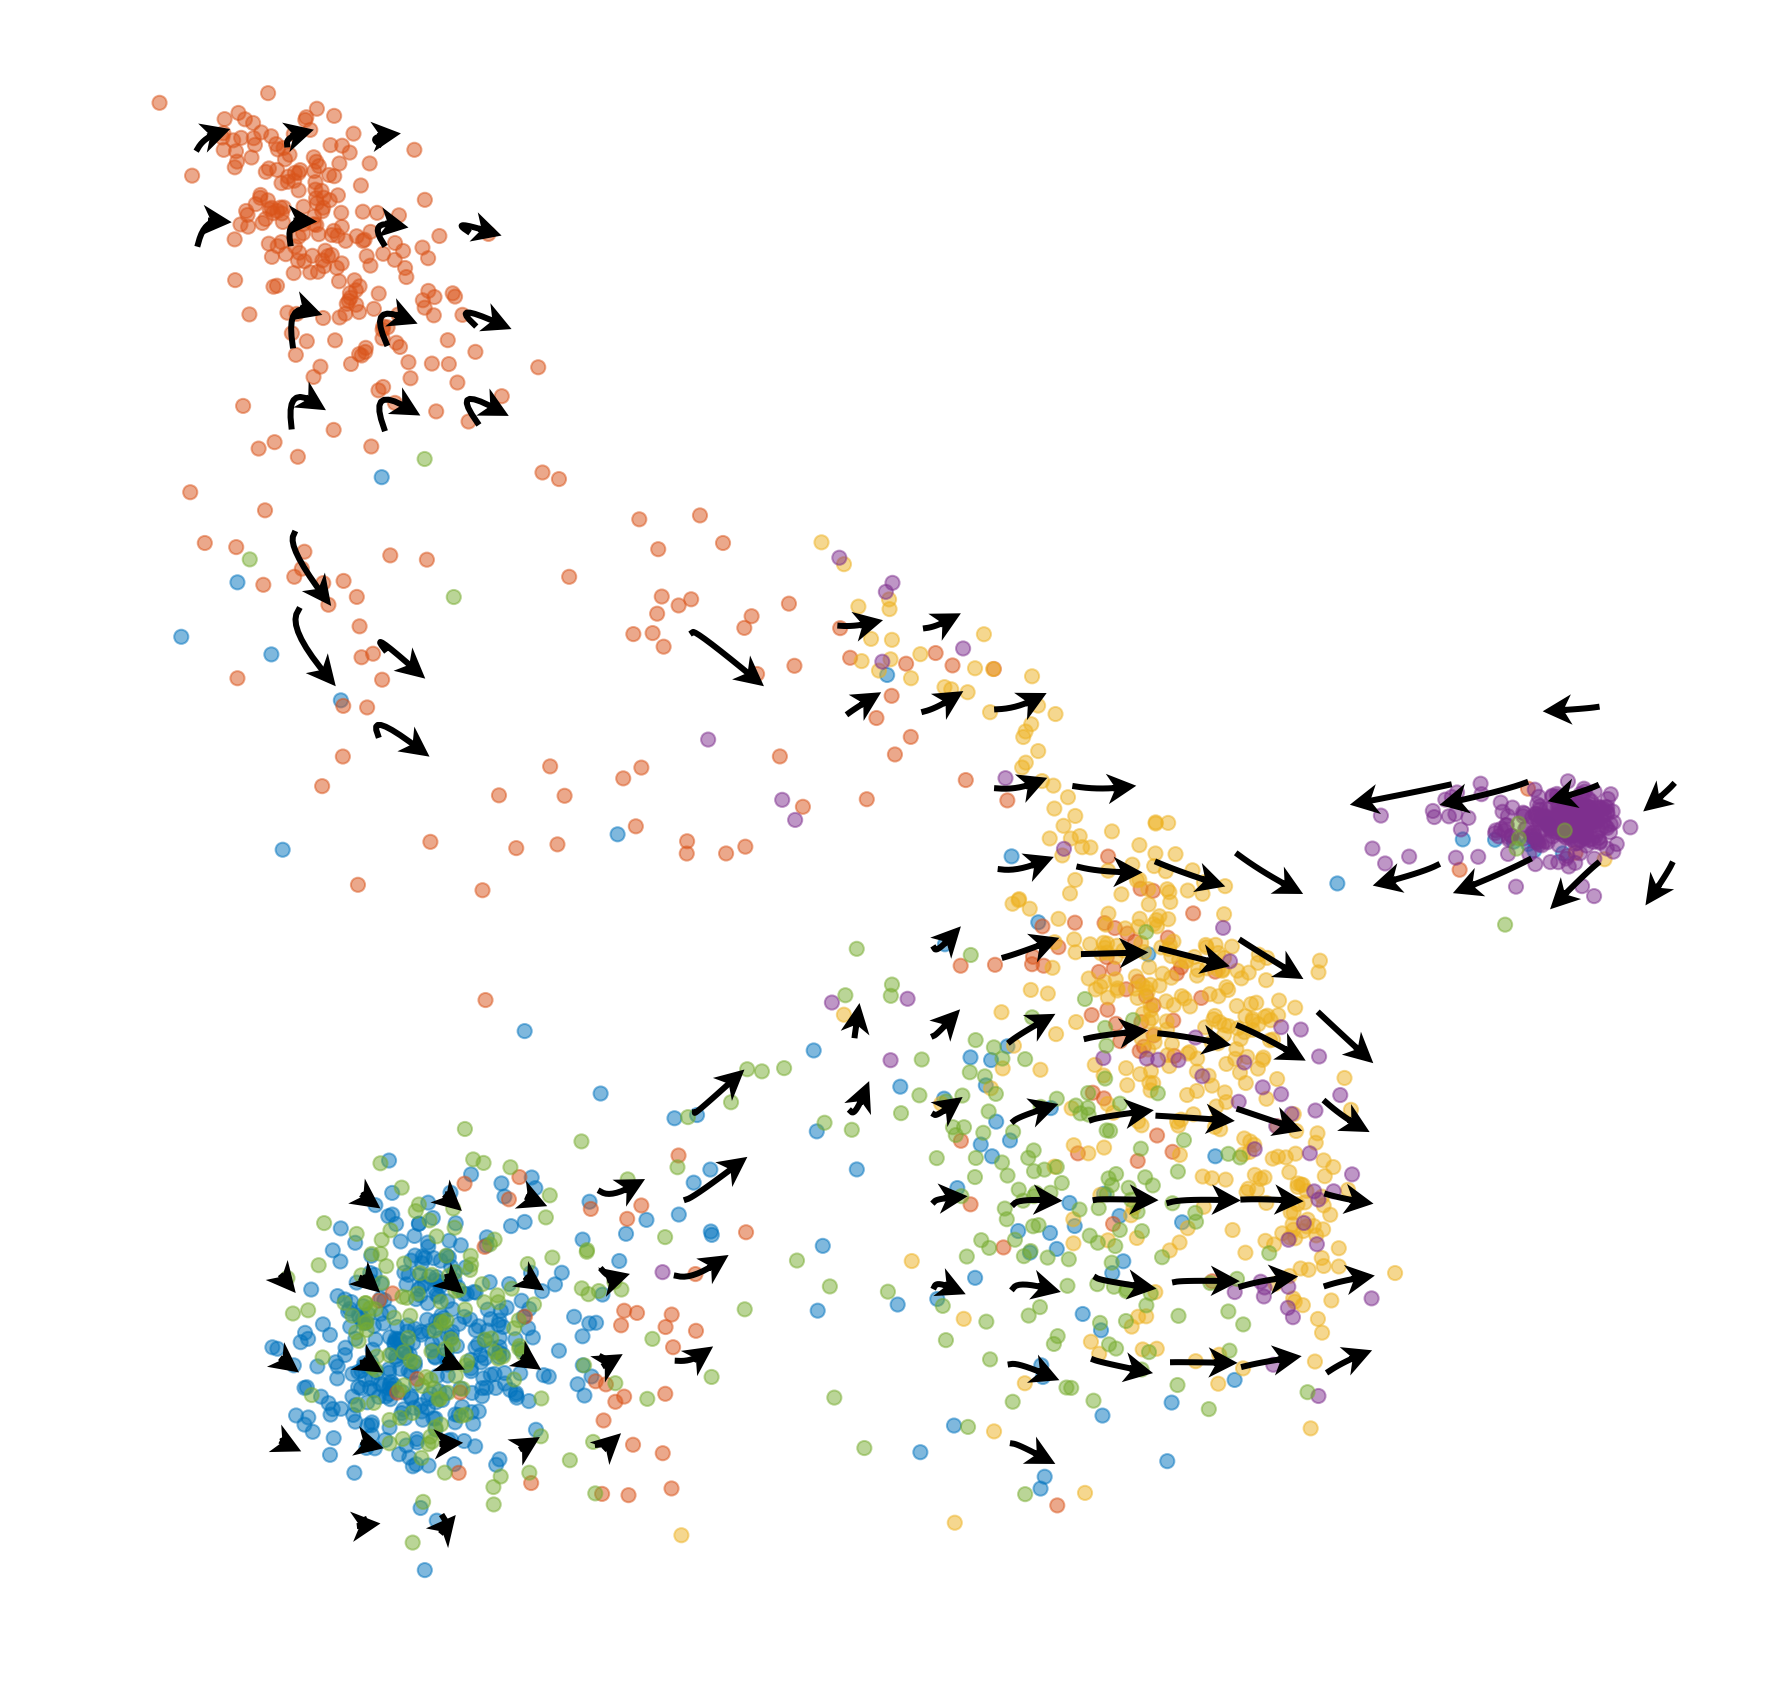

In [61]:
n_curves = XYP.shape[0]


plt.figure(figsize=(15,15))
s_vals = np.linspace(0.0, 1.0, 10)


cc = vlm_p.ca['Clusters']
COLORS = vlm_p.COLORS
for j in range(NUM_CLUS):
#     print(cc==j)
    nC = np.sum(cc==j)
    col=np.matlib.repmat(COLORS[j],nC,1)
    plt.scatter(vlm_p.embedding[cc==j, 0], vlm_p.embedding[cc==j, 1],c=col,alpha=0.5,s=50,edgecolors=None)
    
    
ARR_SCAL = 100;
for i in range(n_curves):
    nodes = np.asfortranarray([[XYM[i, 0]-UVP[i, 0], XYM[i, 0], XYM[i, 0]+UVM[i, 0]],
             [XYM[i, 1]-UVP[i, 1], XYM[i, 1], XYM[i, 1]+UVM[i, 1]]])
    curve = bezier.Curve(nodes, degree=1)
    a = curve.evaluate_multi(s_vals)
    arr_len = [a[0,-1]-a[0,-2],a[1,-1]-a[1,-2]]    
    arr_vec = np.asarray(arr_len)
    ARRLENSCAL = np.linalg.norm(arr_vec, ord=2, axis=0)
    if ARRLENSCAL>0:
        arr_vec /= ARRLENSCAL
        arr_vec_perp = np.asarray( [arr_vec[1],-arr_vec[0]])

        LEN = 0.25
        WID = LEN*0.7
        BK = 0.1
        CC = a[:,-1]
        C_off = LEN*0.5
        CC -= arr_vec*C_off

        patch_x = np.asarray([CC[0], 
                              CC[0] - WID * arr_vec_perp[0] - arr_vec[0]*BK, 
                              CC[0] + LEN * arr_vec[0],
                              CC[0] + WID * arr_vec_perp[0] - arr_vec[0]*BK,
                              CC[0]])
        patch_y = np.asarray([CC[1], 
                              CC[1] - WID * arr_vec_perp[1] - arr_vec[1]*BK, 
                              CC[1] + LEN * arr_vec[1],
                              CC[1] + WID * arr_vec_perp[1] - arr_vec[1]*BK,
                              CC[1]])
        plt.fill(patch_x,patch_y,'k',alpha=1)


        plt.plot(a[0],a[1],'k',linewidth=3)
_=plt.axis('off')